# **Notebook Summary**

This notebook covers the initial training rounds with enhanced data and pseudo-label strategies to improve bird species classification.

We trained an **MAE model** using an **asymmetric loss** with adjusted gamma parameters to focus on hard samples. Pseudo labels for rare species—those not in the **BirdNET classes**—were generated by combining predictions from the MAE and a Mobilenet model, using only agreed-upon samples for label reliability.

Negative samples were added from soundscapes where **BirdNET** predicted birds outside our **BirdCLEF classes**, validated by high-confidence and region-specific filtering (Colombia).

To address class imbalance, an **oversampling strategy** was applied in training data preparation by controlling augmentation probabilities inversely proportional to class frequencies and capping maximum samples per class. This ensured a more balanced representation of species during training.

Data augmentation included **audio mixing (mixup)** as well as several audio-specific transformations like **reverberation, compression, pitch shifting, time stretching, time shifting, volume changes, and clipping**. These augmentations were applied randomly during training to diversify the data and improve model robustness.

Training used a **Bird-MAE encoder** with a custom classification head, layered optimizer learning rates, gradient accumulation, and cosine annealing scheduler. Performance was monitored using **precision, recall, and F1 metrics** with regular model checkpointing.



# **Imports**

In [1]:
from google.colab import drive, runtime
import zipfile
import os
import pandas as pd
import joblib
import ast
import numpy as np
import warnings
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, label_ranking_average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import librosa
from collections import defaultdict

from transformers import AutoFeatureExtractor, AutoModel

import matplotlib.pyplot as plt
from IPython.display import Audio, display
from tqdm import tqdm

import tensorflow as tf


drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Main_Birdclef/scripts')
import birdclef_utils



Mounted at /content/drive


# **Get Data From Drive**
- Retreive the birdclef-2025 training data
- Retreive other processed data

In [2]:
birdclef_utils.retrieve_and_process_birdclef_data()
birdclef_utils.retrieve_and_process_birdclef_data(zip_filename='ColabUploads.zip')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully extracted all files from birdclef-2025.zip to /content/data
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully extracted all files from ColabUploads.zip to /content/data


# **Directories**

In [3]:
main_dir='/content/data/'
main_processed_dir=os.path.join(main_dir,'ColabUploads')
processed_dir=os.path.join(main_processed_dir,'KaggleUploads')

drive_dir='/content/drive/MyDrive'
main_birdclef_dir=os.path.join(drive_dir,'Main_Birdclef')
csv_dir=os.path.join(main_birdclef_dir,'CSVs')
supplemental_files_dir=os.path.join(main_birdclef_dir,'supplemental_files')
models_dir=os.path.join(main_birdclef_dir,'models')


# **Processed csv and label encoder**
- CSV is derived from train.csv provided by birdclef.  It contains additional columns such as the duration of each audio file and the number of files associated with each species.

In [4]:
warnings.filterwarnings('ignore')
processed_train_csv_path=os.path.join(processed_dir,'speech_cleaned_audio_with_duration.csv')

df = pd.read_csv(processed_train_csv_path, dtype={'primary_label': 'object'})
print(f'Sucessfully loaded processed train.csv from: {processed_train_csv_path}')
df['secondary_labels'] = df['secondary_labels'].apply(ast.literal_eval)

# Path to the label encoder file
label_encoder_path = os.path.join(supplemental_files_dir,'bird_label_encoder.joblib')

try:
    # Load the label encoder
    label_encoder = joblib.load(label_encoder_path)
    print(f"Successfully loaded label_encoder from: {label_encoder_path}")
except FileNotFoundError:
    print(f"Error: File not found at: {label_encoder_path}. "
          f"Please ensure the dataset 'processing-models' is attached and the path is correct.")

Sucessfully loaded processed train.csv from: /content/data/ColabUploads/KaggleUploads/speech_cleaned_audio_with_duration.csv
Successfully loaded label_encoder from: /content/drive/MyDrive/Main_Birdclef/supplemental_files/bird_label_encoder.joblib


# **Data Split**

Training, validation, and testing sets were created by splitting on filename.

## Original Split
- **Training:** 16,985
- **Validation:** 3,016
- **Testing:** 8,574
- **Soundscapes:** 1,698 reserved for potential validation and testing
- **Soundscapes:** 8,028 potentially used for training

## Modifications
- 4,000 files were transferred from the testing set to the training set
- 2,819 soundscape files were added to the training set

## Final File Counts
- **Training:** 22,904
- **Validation:** 3,016
- **Testing:** 4,574


In [5]:
original_train_filenames=np.load(os.path.join(processed_dir,'train_filenames.npy'))
original_test_filenames=np.load(os.path.join(processed_dir,'test_filenames.npy'))
original_val_filenames=np.load(os.path.join(processed_dir,'val_filenames.npy'))
added_fnames=[f for f in original_test_filenames[:4000]]
original_train_filenames=list(original_train_filenames)+added_fnames

print('Length of Train Filenames: ',len(original_train_filenames))

file_mapping=df.set_index('cleaned_filename')['filename'].to_dict()
original_train_filenames=[file_mapping[f] for f in original_train_filenames]
original_val_filenames=[file_mapping[f] for f in original_val_filenames]
original_test_filenames=[file_mapping[f] for f in original_test_filenames]

# Birdnet Predictions for all train_soundscape files and all birds considered
labeled_soundscapes=pd.read_csv(os.path.join(csv_dir, 'birdnet_soft_labels.csv'))
labeled_soundscapes.rename(columns={'file':'filename'},inplace=True)

training_labeled_soundscape_fnames=labeled_soundscapes['filename'].unique()[:3000]
validation_testing_soundscapes=labeled_soundscapes['filename'].unique()[3000:]
labeled_soundscapes_filtered=labeled_soundscapes[labeled_soundscapes['confidence']>0.35]
labeled_soundscape_fnames_filtered=labeled_soundscapes_filtered['filename'].unique()
original_train_filenames=original_train_filenames+[f for f in labeled_soundscape_fnames_filtered if f in training_labeled_soundscape_fnames]
negative_soundscapes=pd.read_csv(os.path.join(csv_dir,'birdnet_negative_samples_data_revised.csv'))
negative_soundscapes_fnames=negative_soundscapes['filename'].unique()
new_num_lab_soundscapes=pd.read_csv(os.path.join(csv_dir,'numeric_labels_soundscapes.csv'))
new_num_lab_soundscapes_fnames=new_num_lab_soundscapes['filename'].unique()
added_num_lab_soundscapes=[f for f in new_num_lab_soundscapes_fnames if f not in validation_testing_soundscapes]
added_neg_soundscapes=[f for f in negative_soundscapes_fnames if f not in validation_testing_soundscapes]
print('Length Added Num Lab Soundscapes: ', len(added_num_lab_soundscapes))
print('Length Added Negative Soundscapes: ', len(added_neg_soundscapes))
original_train_filenames=original_train_filenames+added_neg_soundscapes+added_num_lab_soundscapes
print()

print('Final Length of Train Filenames: ',len(original_train_filenames))
print('Final Length of Val Filenames: ',len(original_val_filenames))
print('Final Length of Test Filenames: ',len(original_test_filenames[4000:]))

Length of Train Filenames:  20985
Length Added Num Lab Soundscapes:  145
Length Added Negative Soundscapes:  100

Final Length of Train Filenames:  22574
Final Length of Val Filenames:  3016
Final Length of Test Filenames:  4574


# **Pseudo‑Labeling**

The `retrieveData` class provides hard and soft labels for given filenames and start times, using a variety of CSV files containing pseudo‑labels generated from BirdNET and custom models.

## Pseudo‑Label Sources

### BirdNET‑Derived
- **`birdnet_train_labels_final.csv`**  
  BirdNET confidences for all assigned *primary labels* in `train_audio`.
- **`birdnet_secondary_label_detections.csv`**  
  BirdNET confidences for all assigned *secondary labels* in `train_audio`.
- **`birdnet_soft_labels.csv`**  
  BirdNET confidences for `train_soundscapes`.

### Non‑BirdNET Model‑Derived
- **`non_birdnet_confidences_from_softmax.csv`**  
  Confidences for assigned primary labels **not in BirdNET training data**, generated using a custom model trained on random start times (`train_audio`).
- **`non_birdnet_confidences_from_softmax_short_files.csv`**  
  Additional confidences for primary labels **not in BirdNET classes** from shorter audio files (`train_audio`).
- **`added_secondary_labels_non_birdnet.csv`**  
  Confidences for assigned secondary labels in classes **not in BirdNET classes**.
- **`non_birdnet_confidences_from_MAE.csv`**  
  Confidences for non‑BirdNET classes from the MAE model after training on `train_audio`.

### Special Cases & Corrections
- **`birdnet_negative_samples_data.csv`**  
  Filenames and start times for birds **not in BirdCLEF‑2025 classes** but given high confidence by BirdNET — used as *negative samples*.
- **`rows_to_replace1.csv`**  
  Data believed to be misclassified by BirdNET, likely because the true label is actually a non‑BirdNET class.

## Other Supporting Files
- **`birdnet_confidence_thresholds.npy`**  
  Per‑class thresholds used to decide if a label should be converted to a **hard label**.

## Methodology
1. Run BirdNET on all **primary labels** in `train_audio` to obtain confidences.
2. For each bird species, compute the **lower quartile** of all confidences across the dataset.
3. Use this value as a class‑specific **confidence threshold**:
   - For `train_soundscapes`: convert soft labels to *hard labels* if the confidence exceeds the threshold.
   - For `train_audio`: all assigned primary labels are converted to hard labels by default.
4. Non‑BirdNET class confidences are generated using custom models (Softmax classifier, MAE model) trained on `train_audio`.



In [6]:
class RetreiveData:
    def __init__(self, labels_df):
        self.labels_df = labels_df
        self.label_encoder = joblib.load(os.path.join(supplemental_files_dir,'bird_label_encoder.joblib'))
        self.start_time_info = pd.read_csv(os.path.join(csv_dir,'birdnet_train_labels_final.csv'))
        self.high_confidence_all=np.load(os.path.join(supplemental_files_dir,'high_conf_start_times_dict_all.npy'),allow_pickle=True).item()
        self.start_time_info['is_soundscape']=False
        self.start_time_info['is_secondary']=False
        self.start_time_info_secondary_labels = pd.read_csv(os.path.join(csv_dir, 'birdnet_secondary_label_detections.csv'))
        self.start_time_info_secondary_labels['is_soundscape']=False
        self.start_time_info_secondary_labels['is_secondary']=True
        self.labeled_soundscapes = pd.read_csv(os.path.join(csv_dir, 'birdnet_soft_labels.csv'))
        self.labeled_soundscapes=self.labeled_soundscapes[self.labeled_soundscapes['confidence']>0.35]

        self.labeled_soundscapes['is_secondary'] = True
        self.labeled_soundscapes['is_soundscape']=True
        self.labeled_soundscapes = self.labeled_soundscapes.rename(columns={'file': 'filename'})
        self.list_of_labeled_soundscapes = list(self.labeled_soundscapes['filename'].values)
        self.list_of_train_filenames = list(self.start_time_info['filename'].values)
        self.unlabeled_soundscapes = np.load(os.path.join(supplemental_files_dir,'unlabeled_background_files.npy'), allow_pickle=True)
        self.start_time_info_two = pd.read_csv(os.path.join(csv_dir, 'non_birdnet_confidences_from_softmax.csv'))
        self.start_time_info_three=pd.read_csv(os.path.join(csv_dir,'non_birdnet_confidences_from_softmax_short_files.csv'))
        self.start_time_info_two['primary_label'] = self.start_time_info_two['primary_label'].astype(str)
        self.start_time_info_two['is_secondary'] = False
        self.start_time_info_two['is_soundscape']=False

        self.start_time_info_three['is_secondary'] = False
        self.start_time_info_three['is_soundscape']=False
        self.start_time_info_four=pd.read_csv(os.path.join(csv_dir,'added_secondary_labels_non_birdnet.csv'))
        self.start_time_info_four['primary_label']=self.start_time_info_four['primary_label'].astype(str)
        self.start_time_info_four['is_secondary']=True
        self.start_time_info_four['is_soundscape']=False

        self.start_time_info_five=pd.read_csv(os.path.join(csv_dir,'non_birdnet_confidences_from_MAE.csv'))
        self.start_time_info_five['primary_label']=self.start_time_info_five['primary_label'].astype(str)
        self.start_time_negatives=pd.read_csv(os.path.join(csv_dir,'birdnet_negative_samples_data_revised.csv'))
        self.start_time_negatives['primary_label']=None
        self.start_time_negatives['is_secondary']=False
        self.start_time_negatives['is_soundscape']=True
        self.start_time_negatives['confidence']=0.0

        self.start_time_info_non_birdnet_soundscapes=pd.read_csv(os.path.join(csv_dir,'numeric_labels_soundscapes.csv'))
        self.start_time_info_non_birdnet_soundscapes['is_secondary']=False
        self.start_time_info_non_birdnet_soundscapes['is_soundscape']=True
        rows_to_destroy=pd.read_csv(os.path.join(csv_dir, 'rows_to_replace1.csv'))
        self.data = pd.concat([
            self.start_time_info,
            self.labeled_soundscapes,
            self.start_time_info_two,
            self.start_time_info_secondary_labels,
            self.start_time_info_three,
            self.start_time_info_four,
            self.start_time_info_five,
            self.start_time_negatives,
            self.start_time_info_non_birdnet_soundscapes
        ])
        self.data['primary_label'] = self.data['primary_label'].astype(str).str.strip()
        self.remove_rows(rows_to_destroy)

        self.all_filenames = self.data['filename'].values
        self.all_possible_filenames = pd.read_csv(os.path.join(main_dir,'train.csv'))['filename'].values
        self.non_birdnet_labels = np.load(os.path.join(supplemental_files_dir,'non_birdnet_labels.npy'), allow_pickle=True)
        self.birdnet_thresholds=np.load(os.path.join(supplemental_files_dir,'birdnet_confidence_thresholds.npy'),allow_pickle=True).item()

    def remove_rows(self, rows_to_destroy_df):
      cols = self.data.columns.tolist()
      before_count = len(self.data)

      self.data = self.data[
          ~self.data.set_index(['filename', 'start_time', 'primary_label']).index.isin(
              rows_to_destroy_df.set_index(['filename', 'start_time', 'primary_label']).index
          )
      ]

      after_count = len(self.data)
      print(f"Removed {before_count - after_count} rows.")

      # Restore column order and reset index
      self.data = self.data[cols].reset_index(drop=True)

    def get_random_file_for_mix(self,filter_files,use_soundscape=False):
        included_fnames=[f[0] for f in filter_files]
        if use_soundscape:
          data=self.data[self.data['is_soundscape']==True]
          confidence_threshold=0.30
        else:
          data=self.data[self.data['is_soundscape']==False]
          confidence_threshold=0.60
        data=data[data['filename'].isin(included_fnames)]
        possible_files=data[data['confidence']>confidence_threshold]['filename'].values
        chosen_file=random.choice(possible_files)
        filename, primary_labels, soft_labels, start_time, file_kind=self.get_file_and_start_time(chosen_file,get_ahead=False)
        if start_time  in [None,'skip']:
          return self.get_random_file_for_mix(use_soundscape=use_soundscape)
        else:
          return filename, primary_labels, soft_labels, start_time, file_kind


    def adjust_confidence(self,row):
      if row['is_secondary']:
        if row['confidence']>0.5:
          return 1
        else:
          return row['confidence']
      else:
        if row['confidence']>0.40:
          return 1
        else:
          return row['confidence']

    def apply_threshold(self, row, thresholds):
      """
      Scale or hard-label BirdNET confidence values
      based on per-species thresholds.

      Args:
          row (pd.Series): Must have 'primary_label' and 'confidence' columns.
          thresholds (dict): Mapping {label: threshold_value}.

      Returns:
          float: Scaled confidence or hard label (1.0).
      """
      label = row['primary_label']
      conf = row['confidence']


      # Get species-specific threshold, fallback None if missing
      threshold = thresholds.get(label, None)

      if threshold is None or threshold <= 0:
          # No valid threshold — return original conf
          return conf

      # Above threshold → hard-label
      if conf > threshold:
          return 1.0

      # Otherwise → scale relative to threshold
      return conf / threshold


    def adjust_confidence(self, row):
      try:
          threshold = self.gbvc_thresholds[row['primary_label']]
          confidence = row['confidence']
          if confidence > threshold:
              return 1.0
          else:
              return confidence / threshold
      except Exception:
          return row['confidence']


    def get_file_and_start_time(self, filename,start_time,get_ahead=True):
      if get_ahead:
        seconds_ahead=3
      else:
        seconds_ahead=0
      file_info = filename.split('/')[0]
      file_kind = 'train_birds' if file_info in self.label_encoder.classes_ else 'soundscapes'
      primary_labels = []
      soft_labels = []
      data = self.data[(self.data['filename'] == filename)&(self.data['start_time']>=start_time)&(self.data['start_time']<=start_time+seconds_ahead)]
      agg = data.groupby('primary_label')['confidence'].sum().reset_index()
      agg['confidence'] = agg.apply(lambda row: self.apply_threshold(row, self.birdnet_thresholds), axis=1)

      primary_labels = agg['primary_label'].tolist()
      soft_labels = agg['confidence'].tolist()
      if file_kind=='train_birds':
        soft_labels=[1 for _ in soft_labels]
      return filename, primary_labels, soft_labels, start_time, file_kind


# Usage Example:
#random.shuffle(train_filenames)
birdnet_data = RetreiveData(df.set_index('filename'))
for i in range(10):
    fname, labels, soft_labels, start_time, file_kind = birdnet_data.get_file_and_start_time(original_train_filenames[i],0,get_ahead=False)
    print(f'Filename: {fname}, Start Time: {start_time}, Labels: {labels}, Soft Labels: {soft_labels}, File Kind: {file_kind}')
    print(type(labels))

Removed 12 rows.
Filename: srwswa1/XC731562.ogg, Start Time: 0, Labels: [], Soft Labels: [], File Kind: train_birds
<class 'list'>
Filename: laufal1/XC162234.ogg, Start Time: 0, Labels: ['laufal1'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: tbsfin1/XC531783.ogg, Start Time: 0, Labels: ['tbsfin1'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: sobtyr1/XC394644.ogg, Start Time: 0, Labels: [], Soft Labels: [], File Kind: train_birds
<class 'list'>
Filename: blcjay1/XC632614.ogg, Start Time: 0, Labels: ['blcjay1'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: 22976/iNat1226844.ogg, Start Time: 0, Labels: ['22976'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: laufal1/XC692843.ogg, Start Time: 0, Labels: [], Soft Labels: [], File Kind: train_birds
<class 'list'>
Filename: rugdov/XC243469.ogg, Start Time: 0, Labels: ['rugdov'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: piepuf1/XC1130

## **Oversampling / Balancing**

To address class imbalance in the training data, we calculate the number of samples for each `primary_label` in the BirdNET dataset and adjust the sampling strategy accordingly.

### Steps:
1. **Count samples per class**  
   Compute `value_counts()` for `primary_label` to see dataset imbalance and total number of classes.

2. **Compute augmentation probabilities**  
   For each class, define an `augmentation_prob` based on its count relative to the max class size.  
   - Rare classes get a higher chance of augmentation.
   - Majority classes have low augmentation probability.

3. **Set limits**  
   - `max_samples`: cap on the number of samples per class (e.g., 15,000).  
   - `final_size`: target total number of training samples after balancing (e.g., 70,000).

4. **Resample per class**  
   For each `primary_label` group:  
   - **Downsample** if above `max_samples`.  
   - **Oversample** (with replacement) if below `max_samples`.  
   - Randomly set `aug_flag` per sample based on `augmentation_prob`, indicating whether augmentation should be applied later.

5. **Combine and shuffle**  
   All selected filenames (original and augmented) are combined into a single shuffled training list and truncated to the target `final_size`.

**Outcome:**  
This process ensures representation for under‑represented classes while preventing over‑representation of dominant classes, creating a more balanced and diverse training set for the model.


In [7]:
data_balance=birdnet_data.data['primary_label'].value_counts()
print('Original Balance of Data')
print('Number of Classes: ', len(birdnet_data.data['primary_label'].unique()))
for label in data_balance.index:
  print(f"{label}: {data_balance[label]}")

# Calculate augmentation probabilities
max_count = max(data_balance.values)  # 16539 for compau
augmentation_probs = {label: 1 - (count / (max_count+100)) for label, count in data_balance.items()}
augmentation_probs
max_samples = 15000
final_size = 70000
training_filenames = []
applicable_google_data = birdnet_data.data[birdnet_data.data['filename'].isin(original_train_filenames)]

grouped = applicable_google_data.groupby('primary_label')

for bird, data in grouped:
    aug_prob = augmentation_probs[bird]
    n_original = len(data)

    # Downsample or shuffle so order is random
    if n_original > max_samples:
        data = data.sample(max_samples, random_state=42)
        n_original = max_samples

    # Add original samples
    aug_flags = np.random.rand(n_original) < aug_prob
    for (idx, row), aug_flag in zip(data.iterrows(), aug_flags):
        training_filenames.append((row['filename'], row['start_time'], aug_flag, bird))

    # Add augmented samples if needed
    n_needed = max_samples - n_original
    if n_needed > 0:
        sampled_aug = data.sample(n_needed, replace=True, random_state=42)
        aug_flags = np.random.rand(n_needed) < aug_prob
        for (idx, row), aug_flag in zip(sampled_aug.iterrows(), aug_flags):
            training_filenames.append((row['filename'], row['start_time'], aug_flag, bird))

random.shuffle(training_filenames)
training_filenames = training_filenames[:final_size]

Original Balance of Data
Number of Classes:  207
compau: 7904
laufal1: 7341
grekis: 6477
gycwor1: 5293
trokin: 5161
bkmtou1: 4253
roahaw: 4116
blbgra1: 4006
bobfly1: 3747
banana: 3665
whtdov: 3632
pirfly1: 3611
trsowl: 3557
strcuc1: 3461
strfly1: 3225
saffin: 3176
soulap1: 3060
socfly1: 3052
colcha1: 2777
wbwwre1: 2774
yercac1: 2716
chbant1: 2510
yeofly1: 2507
52884: 2485
littin1: 2449
sobtyr1: 2445
butsal1: 2367
yecspi2: 2282
whbman1: 2198
speowl1: 2193
bbwduc: 2096
50186: 2065
bubwre1: 1977
smbani: 1934
amekes: 1903
orcpar: 1772
bkcdon: 1654
pavpig2: 1531
ywcpar: 1520
bugtan: 1514
tropar: 1512
yebela1: 1477
greani1: 1462
rutjac1: 1431
rumfly1: 1392
blcjay1: 1389
rugdov: 1377
whfant1: 1358
paltan1: 1355
compot1: 1354
greegr: 1319
linwoo1: 1309
blhpar1: 1293
22973: 1293
cotfly1: 1254
creoro1: 1250
blbwre1: 1184
rinkin1: 1181
65448: 1125
chfmac1: 1123
22976: 1120
baymac: 1068
yebsee1: 1056
715170: 1049
rtlhum: 1034
plbwoo1: 1007
gohman1: 992
555086: 992
yebfly1: 986
cocwoo1: 956
cattyr:

In [8]:
neg_samples=[f for f in training_filenames if f[3]=='None']
print(f"Length of Negative Samples: {len(neg_samples)}")

Length of Negative Samples: 336


In [9]:
max_samples = 15000
final_size_val = 10000  # Or set to whatever validation size you want

validation_filenames = []
applicable_val_data = birdnet_data.data[birdnet_data.data['filename'].isin(original_val_filenames)]

grouped_val = applicable_val_data.groupby('primary_label')

for bird, group_data in grouped_val:
    n_original = len(group_data)

    # Downsample or shuffle so order is random
    if n_original > max_samples:
        group_data = group_data.sample(max_samples, random_state=42)
        n_original = max_samples

    # Add original samples with augmentation flag always False
    for idx, row in group_data.iterrows():
        validation_filenames.append((row['filename'], row['start_time'], False, bird))

    # Add augmented samples if needed, with augmentation flag always False
    n_needed = max_samples - n_original
    if n_needed > 0:
        sampled_aug = group_data.sample(n_needed, replace=True, random_state=42)
        for idx, row in sampled_aug.iterrows():
            validation_filenames.append((row['filename'], row['start_time'], False, bird))

random.shuffle(validation_filenames)
validation_filenames = validation_filenames[:final_size_val]



## **Custom PyTorch Dataset for Bird Audio Classification**

This `BirdAudioDataset` class is a PyTorch `Dataset` designed for loading and augmenting 5-second audio clips of bird sounds, along with their multi-label targets, for training and validation.

### Key Features:

- **Initialization (`__init__`)**  
  - Takes a list of audio file metadata tuples (`filename, start_time, augment_flag, expected_bird`).  
  - Uses a `retrieve_data` object to fetch labels and metadata.  
  - Supports a fixed sample rate (default 32 kHz) and a fixed chunk duration of 5 seconds.

- **Length (`__len__`)**  
  - Returns the total number of samples available based on the `file_list`.

- **Get item (`__getitem__`)**  
  - Loads a 5-second audio chunk from the specified file and offset using `librosa`.  
  - Adjusts start times slightly with random jitter to augment temporal sampling.  
  - Pads clips shorter than 5 seconds to full length.  
  - Optionally applies **audio augmentations** (if `augment_flag` is True).  
  - Pads the 5-second clip to 10 seconds (model input length requirement).  
  - Builds a multi-hot encoded label vector of shape `(num_classes,)` using soft labels fetched from `retrieve_data`.  

### Data Augmentation (`_augment_audio` method)

The dataset applies a variety of random audio augmentations to improve model robustness:

- **Reverb:** Simple delay/reverberation effect applying feedback echo.
- **Compression:** Soft clipping with random gain to simulate dynamic range compression.
- **Time Shifting:** Circularly shifts the waveform by a small random interval (±0.25 seconds).
- **Clipping:** Random amplitude clipping to simulate distortion.
- **Pitch Shifting:** Small pitch shifts (±0.5 semitones).
- **Volume Change:** Random amplitude scaling to simulate loudness variation.
- **Time Stretching:** Speed-up or slow-down time stretching by 0.8–1.2×, with padding/truncation to keep length fixed.

### Time Stretching Helper (`time_stretch_and_pad_truncate`)

- Stretches audio duration by a random rate, then pads or truncates to exactly 5 seconds to maintain consistent input size for the model.

### DataLoader Setup

- Defines a custom `collate_fn` to batch and stack numpy audio arrays and multi-hot labels into PyTorch tensors efficiently.
- Constructs `DataLoader`s for training and validation datasets with batch size 16 and shuffling enabled for training.

---

### Summary

This dataset class provides an end-to-end pipeline for:

- Sampling 5-second bird audio clips from files with flexible offsets,
- Applying realistic audio augmentations,
- Generating soft multi-label targets,
- Preparing padded fixed-size inputs ready for deep learning models.

It is specifically designed to work with your BirdNET pseudo-label retrieval system and seamlessly integrates with PyTorch training workflows.

---




# **Custom Generator**

In [10]:
class BirdAudioDataset(Dataset):
    def __init__(self, filenames, retrieve_data_obj, num_classes, sr=32000):
        """
        Args:
            file_list: list of filenames to sample from
            retrieve_data_obj: instance of your RetreiveData class
            num_classes: total number of bird species/classes in dataset
            sr: target sample rate for audio
        """
        self.all_filenames=filenames
        self.file_list = self.all_filenames
        self.retrieve_data = retrieve_data_obj
        self.num_classes = num_classes
        self.sr = sr
        self.chunk_duration = 5

    def __len__(self):
        return len(self.file_list)
    def on_epoch_end(self):
      n_select = min(10000, len(self.all_filenames))
      # random.sample works fine on a list of tuples/lists
      self.file_list = random.sample(self.all_filenames, n_select)

    def __getitem__(self, idx):
        filename, start_time, augment_flag, expected_bird = self.file_list[idx]

        # Retrieve data from the mock object
        _, primary_labels, soft_labels, _, file_kind = self.retrieve_data.get_file_and_start_time(filename, start_time=start_time)
        #soft_labels = [1 for _ in soft_labels]
        audio_dir = 'train_soundscapes' if file_kind == 'soundscapes' else 'train_audio'
        if start_time>=1:
          start_time+=random.uniform(-0.2,0.2)
        else:
          start_time+=random.uniform(0.0,0.4)
        # Load a 5-second chunk starting from the specified time
        audio, _ = librosa.load(os.path.join(main_dir, audio_dir, filename), sr=self.sr, offset=start_time, duration=5.0)

        # Pad to 5 seconds if the chunk is shorter (e.g., at the end of the file)
        target_5s_length = 5 * self.sr
        audio_length = audio.shape[0]
        if audio_length < target_5s_length:
            pad_width = target_5s_length - audio_length
            audio = np.pad(audio, (0, pad_width), mode='constant')

        if augment_flag:
            audio = self._augment_audio(audio)


        # Create multi-hot encoded label
        multi_label = np.zeros(self.num_classes, dtype=np.float32)
        if primary_labels is not None and soft_labels is not None:
            for primary_label, soft_label in zip(primary_labels, soft_labels):
                if primary_label in self.retrieve_data.label_encoder.classes_:
                    idx_label = self.retrieve_data.label_encoder.transform([primary_label])[0]
                    multi_label[idx_label] = soft_label

        return audio, multi_label, filename,start_time

    def _augment_audio(self, audio):
      """
      Applies data augmentation to the audio.
      Args:
          audio (np.ndarray): The audio waveform (5-second clip).
      Returns:
          np.ndarray: Augmented audio.
      """
      augmented_audio = audio.copy()

      # Reverb (Simple Delay-Based)
      if random.random() < 0.15:
          n_delay_samples = int(0.1 * self.sr)
          feedback = random.uniform(0.2, 0.5)
          reverberated_audio = np.zeros_like(augmented_audio)
          for i in range(len(augmented_audio)):
              reverberated_audio[i] = augmented_audio[i]
              if i >= n_delay_samples:
                  reverberated_audio[i] += feedback * reverberated_audio[i - n_delay_samples]
          augmented_audio = reverberated_audio

      # Compression (Simple Soft Clipping)
      if random.random() < 0.2:
          threshold = random.uniform(0.6, 0.9)
          gain = random.uniform(1.0, 1.5)
          compressed_audio = np.tanh(augmented_audio * gain / threshold) * threshold
          augmented_audio = compressed_audio

      # Time shifting
      if random.random() < 0.1:
          shift_seconds = random.uniform(-0.25, 0.25)
          shift_samples = int(shift_seconds * self.sr)
          augmented_audio = np.roll(augmented_audio, shift_samples)

      if random.random() < 0.05:
          clip_factor = random.uniform(0.7, 0.95)
          augmented_audio = np.clip(augmented_audio, -clip_factor, clip_factor)

      # Pitch shifting
      if random.random() < 0.05:
          n_steps = random.uniform(-0.5, 0.5)
          augmented_audio = librosa.effects.pitch_shift(augmented_audio, sr=self.sr, n_steps=n_steps)

      # Volume change
      if random.random() < 0.2:
          amplitude_factor = random.uniform(0.5, 1.3)
          augmented_audio = augmented_audio * amplitude_factor

      # Time stretching
      if random.random() < 0.1:
          augmented_audio = self.time_stretch_and_pad_truncate(augmented_audio)

      return augmented_audio

    def time_stretch_and_pad_truncate(self, audio):
        """
        Applies time stretching to a 5-second audio signal and then pads or truncates
        it to match the 5-second target length.
        """
        rate = random.uniform(0.8, 1.2)
        sr = self.sr
        target_length = self.sr * self.chunk_duration
        stretched_audio = librosa.effects.time_stretch(audio, rate=rate)

        try:
            current_length = stretched_audio.shape[0]
        except Exception as e:
            print(f'Error in stretching function: {e}')
            return audio

        if current_length < target_length:
            padding = target_length - current_length
            stretched_audio = np.pad(stretched_audio, (0, padding), mode='constant')
        elif current_length > target_length:
            stretched_audio = stretched_audio[:target_length]

        return stretched_audio

random.shuffle(training_filenames)
train_dataset = BirdAudioDataset(training_filenames, birdnet_data, num_classes=206, sr=32000)
val_dataset= BirdAudioDataset(validation_filenames, birdnet_data, num_classes=206, sr=32000)

def collate_fn(batch):
    """
    batch: list of tuples (audio, multi_label, filename, start_time)

    Returns:
      - batched_audio: torch.FloatTensor of shape (batch_size, ...)
      - batched_labels: torch.FloatTensor of shape (batch_size, num_classes)
      - filenames: tuple of filenames
      - start_times: tuple of start times
    """
    # 🎯 FIX: Unpack four values from the batch
    audios, labels, filenames, start_times = zip(*batch)

    # Stack audios: convert list of np arrays to a torch tensor
    audios = torch.tensor(np.stack(audios), dtype=torch.float32)

    # Stack labels as float tensor, shape (batch_size, num_classes)
    labels = torch.tensor(np.stack(labels), dtype=torch.float32)

    # Return the four items
    return audios, labels, filenames, start_times

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)



# **Data Validation**
- Play audio to confirm that it is returning 10 second audio chunk
- Call retrieveData class on training dataset to confirm it is yielding labels for each sample.

In [11]:
num_samples_to_check = 4
sr = 32000

print(f"Playing the first {num_samples_to_check} audio samples and printing labels from the DataLoader...")
print("-" * 50)

for batch_idx, (audio_batch, label_batch, filename_batch,_) in enumerate(train_loader):
    for i in range(min(len(filename_batch), num_samples_to_check)):
        filename = filename_batch[i]
        audio_tensor = audio_batch[i]
        label_tensor = label_batch[i]

        audio_np = audio_tensor.cpu().numpy()

        # 🎯 FIX: Get the indices of the non-zero (positive) labels
        positive_label_indices = torch.where(label_tensor > 0)[0].cpu().numpy()

        # 🎯 FIX: Decode the numerical indices back to their string labels
        decoded_labels = label_encoder.inverse_transform(positive_label_indices)

        print(f"Sample {i+1} from batch {batch_idx+1}: {filename}")
        print(f"Decoded Labels: {list(decoded_labels)}")
        print(f"Tensor shape: {audio_tensor.shape}, Max value: {audio_tensor.max():.2f}")

        display(Audio(data=audio_np, rate=sr))

    break

Playing the first 4 audio samples and printing labels from the DataLoader...
--------------------------------------------------
Sample 1 from batch 1: H65_20230516_073500.ogg
Decoded Labels: ['rugdov']
Tensor shape: torch.Size([160000]), Max value: 0.09


Sample 2 from batch 1: 48124/CSA35118.ogg
Decoded Labels: ['48124']
Tensor shape: torch.Size([160000]), Max value: 0.73


Sample 3 from batch 1: trsowl/XC597612.ogg
Decoded Labels: ['trsowl']
Tensor shape: torch.Size([160000]), Max value: 0.26


Sample 4 from batch 1: yecspi2/XC838704.ogg
Decoded Labels: ['yecspi2']
Tensor shape: torch.Size([160000]), Max value: 0.38


In [ ]:
birdnet_data = RetreiveData(df.set_index('filename'))
for i in range(16):
    fname, labels, soft_labels, start_time, file_kind = birdnet_data.get_file_and_start_time(training_filenames[i][0],training_filenames[i][1],get_ahead=False)
    print(f'Filename: {fname}, Start Time: {start_time}, Labels: {labels}, Soft Labels: {soft_labels}, File Kind: {file_kind}')
    print(type(labels))

Removed 12 rows.
Filename: gohman1/XC636624.ogg, Start Time: 42.0, Labels: ['gohman1'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: fotfly/XC82490.ogg, Start Time: 27.0, Labels: ['fotfly'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: H16_20230515_115500.ogg, Start Time: 0.0, Labels: ['orcpar'], Soft Labels: [1.0], File Kind: soundscapes
<class 'list'>
Filename: sobtyr1/XC244923.ogg, Start Time: 27.0, Labels: ['sobtyr1'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: 67252/XC882999.ogg, Start Time: 242.0, Labels: ['67252'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: 868458/CSA34217.ogg, Start Time: 0.0, Labels: ['868458'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: rumfly1/XC456415.ogg, Start Time: 18.0, Labels: ['rumfly1'], Soft Labels: [1], File Kind: train_birds
<class 'list'>
Filename: babwar/XC189802.ogg, Start Time: 93.0, Labels: ['babwar'], Soft Labels: [1], File Kind: tr

# **Masked Auto Encoder Model**
## Bird-MAE Fine-Tuning and Training Loop

This cell initializes, configures, and trains a Bird-MAE–based classifier for multi‑label bird audio classification, including feature extraction, loss functions, optimizer setup, and a full training/validation loop.

### Key Components



1. **Model Architecture (`BirdMAEForClassification`)**
   - Wraps a pretrained Bird-MAE encoder (`DBD-research-group/Bird-MAE-Base`) with a custom MLP classifier head.
   - Classifier: Dropout → Linear → GELU → Dropout → Linear → GELU → Dropout → Final Linear.
   - Weights initialized with Xavier uniform.

2. **Loss Functions**
   - `AsymmetricLoss`: Focal-like loss that down-weights easy negatives and focuses gradient on hard positives/negatives (configurable `gamma_pos`, `gamma_neg`, `clip`).
   - Early runs used `AsymmetricLoss` with `gamma_pos=0` and `gamma_neg=4` with `clip=0.05`. Later runs used `gamma_pos=0` and `gamma_neg=5` with `clip=0.05`

4. **Optimizer & Learning Rate Scheduling**
  - Using the `AdamW` optimizer with **layer‑wise learning rates**:
    - **Encoder:** `1e-5` (lower for stability) — originally experimented with higher rates (`5e-5`, `4e-5`, `2e-5`) in earlier runs.
    - **Classifier:** `5e-4` — originally higher (`1e-3`, `9e-4`, `7e-4`) in earlier runs.
  - In early experiments, the higher learning rates helped the model adapt quickly but led to less stable convergence.
  - Gradually lowering both encoder and classifier learning rates in later runs improved stability, calibration, and ultimately validation F1.
  - **Weight decay:** `0.01` on both parameter groups.
  - **Scheduler:** `CosineAnnealingLR` with `T_max=10` and `eta_min=1e-6` — decays the learning rate each epoch on a fixed cosine curve, regardless of validation performance.


4. **Training Loop**
   - Supports **gradient accumulation** (`gradient_accumulation_steps=16`) to simulate larger batch sizes.
   - Applies feature extraction per batch using Bird-MAE’s `AutoFeatureExtractor`.
   - Forward pass → compute loss → backpropagate → optimizer step (with gradient clipping).
   - Saves model checkpoint periodically every 300 batches.

5. **Metrics Monitoring**
   - Computes precision, recall, and F1 score at the **sample level** with `average='samples'`.
   - Tracks positive prediction counts, label sparsity, and raw logits stats for diagnostic.
   - Stores and aggregates all predictions/labels for epoch‑level metric calculation.

6. **Validation Loop**
   - Runs model in eval mode, collects validation predictions and metrics.
   - Saves best model checkpoint when validation F1 improves over `best_val_f1`.
   - Updates LR scheduler at the end of each validation epoch.

### Notes
- **Current LR schedule does not depend on improvement** — `CosineAnnealingLR` lowers LR each epoch on a fixed curve.
- The architecture and loss are tuned for **multi‑label classification of bird calls** from both `train_audio` and `train_soundscapes`.
- Frequently training was stopped after 1 or 2 epochs to regenerate the training data.  Roughly 10000 files were passed at a time running 1 to 2 epochs before passing in new data.
- Interestingly specAug seemed to hinder model performance.

In [12]:
def spec_augment(mel_spectrogram, time_mask_param=1, num_time_masks=20, freq_mask_param=1, num_freq_masks=10):
    """
    Applies time and frequency masking to a single-channel spectrogram tensor.

    Args:
        mel_spectrogram: torch.Tensor, shape (time, freq).
        ... (same params as before) ...

    Returns:
        torch.Tensor: augmented mel_spectrogram (same shape as input).
    """
    augmented_mel = mel_spectrogram.clone() # Use .clone() for PyTorch tensors

    num_time_steps = augmented_mel.shape[0]
    num_freq_bins = augmented_mel.shape[1]

    # --- Time Masking ---
    for _ in range(num_time_masks):
        t = torch.randint(0, time_mask_param + 1, (1,)).item()
        if t > 0 and num_time_steps > t:
            t0 = torch.randint(0, num_time_steps - t + 1, (1,)).item()
            augmented_mel[t0:t0 + t, :] = 0

    # --- Frequency Masking ---
    if freq_mask_param is not None and num_freq_masks > 0:
        for _ in range(num_freq_masks):
            f = torch.randint(0, freq_mask_param + 1, (1,)).item()
            if f > 0 and num_freq_bins > f:
                f0 = torch.randint(0, num_freq_bins - f + 1, (1,)).item()
                augmented_mel[:, f0:f0 + f] = 0

    return augmented_mel

# ----------------- Improved Model Definition -----------------
class BirdMAEForClassification(nn.Module):
    def __init__(self, encoder, num_labels, hidden_dim=512, pooling_strategy='mean'):
        super().__init__()
        self.encoder = encoder
        self.pooling_strategy = pooling_strategy

        # Get the actual embedding dimension from the encoder
        embed_dim = encoder.config.embed_dim  # This is 768 from your config

        print(f"Creating classifier with embed_dim: {embed_dim}")

        # Create the MLP classifier head immediately
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_dim // 2, num_labels)
        )

        # Initialize classifier weights properly
        self._init_classifier_weights()

    def _init_classifier_weights(self):
        """Initialize classifier weights with proper scaling"""
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, pixel_values=None):
        outputs = self.encoder(pixel_values, return_dict=True)

        # Get the last hidden state - Bird-MAE already does global pooling
        embeddings = outputs.last_hidden_state  # Shape: [batch_size, embed_dim]

        # Pass through classifier (no pooling needed since it's already done)
        logits = self.classifier(embeddings)

        return logits

# ----------------- Loss Functions (Keep your existing ones) -----------------
class BalancedBinaryLoss(nn.Module):
    def __init__(self, weight_pos=0.49, weight_neg=0.51, epsilon=1e-7):
        super(BalancedBinaryLoss, self).__init__()
        self.weight_pos = weight_pos
        self.weight_neg = weight_neg
        self.epsilon = epsilon

    def forward(self, preds, targets):
        preds_sigmoid = torch.sigmoid(preds)
        preds_clamped = torch.clamp(preds_sigmoid, self.epsilon, 1 - self.epsilon)
        bce = F.binary_cross_entropy(preds_clamped, targets, reduction='none')

        pos_mask = (targets == 1).float()
        neg_mask = (targets == 0).float()

        pos_loss = (bce * pos_mask).sum(dim=1) / (pos_mask.sum(dim=1) + self.epsilon)
        neg_loss = (bce * neg_mask).sum(dim=1) / (neg_mask.sum(dim=1) + self.epsilon)

        balanced_loss = self.weight_pos * pos_loss + self.weight_neg * neg_loss
        return balanced_loss.mean()

class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_pos=0, gamma_neg=4, clip=0.05, eps=1e-8):
        super(AsymmetricLoss, self).__init__()
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.clip = clip
        self.eps = eps

    def forward(self, preds, targets):
        preds_sigmoid = torch.sigmoid(preds)
        preds_pos = preds_sigmoid
        preds_neg = 1 - preds_sigmoid

        if self.clip is not None and self.clip > 0:
            preds_neg = (preds_neg + self.clip).clamp(max=1)

        loss_pos = targets * torch.log(preds_pos.clamp(min=self.eps))
        loss_neg = (1 - targets) * torch.log(preds_neg.clamp(min=self.eps))

        loss_pos *= (1 - preds_pos).pow(self.gamma_pos)
        loss_neg *= (preds_pos).pow(self.gamma_neg)

        loss = - (loss_pos + loss_neg).mean()
        return loss

# Helper functions for metrics
def logits_to_preds(logits, threshold=0.5):
    probs = torch.sigmoid(logits)
    return (probs > threshold).cpu().numpy().astype(int)

def soft_labels_to_hard_labels(labels_tensor, threshold=0.5):
    return (labels_tensor > threshold).numpy().astype(int)

# ----------------- Improved Model Initialization -----------------
encoder = AutoModel.from_pretrained("DBD-research-group/Bird-MAE-Base", trust_remote_code=True)
feature_extractor = AutoFeatureExtractor.from_pretrained("DBD-research-group/Bird-MAE-Base", trust_remote_code=True)

# Debug: Print encoder configuration
print("Encoder config attributes:")
for attr in dir(encoder.config):
    if not attr.startswith('_') and not callable(getattr(encoder.config, attr)):
        try:
            value = getattr(encoder.config, attr)
            print(f"  {attr}: {value}")
        except:
            print(f"  {attr}: <error accessing>")
# Create MAE directory inside models_dir
mae_dir = os.path.join(models_dir, 'MAE')
os.makedirs(mae_dir, exist_ok=True)

best_val_f1=0.8951 # 0.8797 #0.8723 #0.8686#0.8567#0.8503 #0.8388#0.8332#0.8237 #0.7908 #0.7877
num_labels = 206
model = BirdMAEForClassification(encoder, num_labels, hidden_dim=512, pooling_strategy='mean')
# 2. Load the state dictionary
checkpoint_num=21
model_path =  os.path.join(mae_dir,f'bird_mae_classifier_checkpoint_{checkpoint_num}.pt')

model.load_state_dict(torch.load(model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Choose your loss function
criterion = AsymmetricLoss(gamma_pos=0, gamma_neg=5, clip=0.05)

# ----------------- Improved Optimizer Configuration -----------------
# Better learning rates with layer-wise decay
optimizer_parameters = [
    # Encoder layers with lower learning rate
    {'params': model.encoder.parameters(), 'lr': 1e-5, 'weight_decay': 0.01}, # original: 5e-5,4e-5,2e-5
    # Classifier with higher learning rate
    {'params': model.classifier.parameters(), 'lr': 5e-4, 'weight_decay': 0.01} # original: 1e-3,9e-4, 7e-4
]
optimizer = optim.AdamW(optimizer_parameters, betas=(0.9, 0.999), eps=1e-8)

# Add learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

num_epochs = 6
gradient_accumulation_steps = 16

# ----------------- Improved Training Loop -----------------
for epoch in range(num_epochs):
    train_dataset.on_epoch_end()
    # --- Training Loop ---
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    optimizer.zero_grad()

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    for batch_idx, (audio_batch, label_batch, _,_) in enumerate(train_loader, 1):
        try:
            # Convert audio to numpy if needed
            if isinstance(audio_batch[0], torch.Tensor):
                batch_np = [a.numpy() for a in audio_batch]
            else:
                batch_np = audio_batch

            # Improved feature extraction with consistent parameters
            inputs = feature_extractor(
                batch_np,
                return_tensors="pt",

                padding=True,
                truncation=True
            )
            if random.random() < 0.1:
              inputs=spec_augment(inputs)
            # Handle different possible return formats from feature extractor
            if isinstance(inputs, dict):
                pixel_values = inputs['input_values'].to(device)
            else:
                pixel_values = inputs.to(device)

            # Ensure correct shape: if 3D, add channel dimension
            if len(pixel_values.shape) == 3:
                pixel_values = pixel_values.unsqueeze(1)

            labels = label_batch.to(device)

            # Forward pass
            outputs = model(pixel_values=pixel_values)
            loss = criterion(outputs, labels) / gradient_accumulation_steps
            loss.backward()

            # Gradient accumulation
            if (batch_idx % gradient_accumulation_steps == 0) or (batch_idx == len(train_loader)):
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item() * gradient_accumulation_steps

            # Calculate batch metrics
            batch_preds = logits_to_preds(outputs, threshold=0.5)
            batch_targets = soft_labels_to_hard_labels(labels.cpu(), threshold=0.5)

            all_preds.append(batch_preds)
            all_targets.append(batch_targets)

            # Calculate and display metrics every 20 batches to monitor learning
            if batch_idx % 20 == 0:
                precision = precision_score(batch_targets, batch_preds, average='samples', zero_division=0)
                recall = recall_score(batch_targets, batch_preds, average='samples', zero_division=0)
                f1 = f1_score(batch_targets, batch_preds, average='samples', zero_division=0)
                current_lr = optimizer.param_groups[0]['lr']

                # Calculate diagnostic metrics to understand what's happening
                avg_predictions_per_sample = batch_preds.sum(axis=1).mean()
                avg_labels_per_sample = batch_targets.sum(axis=1).mean()
                prediction_sparsity = (batch_preds == 0).mean()

                # Check if model is just predicting everything as positive/negative
                total_positive_preds = batch_preds.sum()
                total_positive_labels = batch_targets.sum()
                total_predictions = batch_preds.size

                # Look at the raw logits to see if they're reasonable
                with torch.no_grad():
                    logits_stats = {
                        'min': outputs.min().item(),
                        'max': outputs.max().item(),
                        'mean': outputs.mean().item(),
                        'std': outputs.std().item()
                    }

                print(f"Batch [{batch_idx:3d}/{len(train_loader)}] "
                      f"Loss: {loss.item() * gradient_accumulation_steps:.4f} "
                      f"P: {precision:.3f} R: {recall:.3f} F1: {f1:.3f} "
                      f"| Pred+: {total_positive_preds}/{total_predictions} "
                      f"Label+: {total_positive_labels} "
                      f"| Logits: μ={logits_stats['mean']:.2f} σ={logits_stats['std']:.2f} "
                      f"range=[{logits_stats['min']:.2f}, {logits_stats['max']:.2f}]")
            if batch_idx % 300 == 0:
              # Assuming 'model' is your trained BirdMAEForClassification instance
              model_path = os.path.join(mae_dir,'bird_mae_classifier_sl.pt')

              # Save only the model's state dictionary
              torch.save(model.state_dict(), model_path)
              print(f"Model saved to {model_path}")
        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            continue

    # Epoch training summary
    if all_preds and all_targets:
        all_preds_epoch = np.vstack(all_preds)
        all_targets_epoch = np.vstack(all_targets)
        epoch_precision = precision_score(all_targets_epoch, all_preds_epoch, average='samples', zero_division=0)
        epoch_recall = recall_score(all_targets_epoch, all_preds_epoch, average='samples', zero_division=0)
        epoch_f1 = f1_score(all_targets_epoch, all_preds_epoch, average='samples', zero_division=0)
        avg_train_loss = running_loss / max(1, len(train_loader) // gradient_accumulation_steps)

        print(f"\nTraining Summary - Epoch {epoch+1}: "
              f"Loss: {avg_train_loss:.4f} Precision: {epoch_precision:.4f} "
              f"Recall: {epoch_recall:.4f} F1: {epoch_f1:.4f}")

    # --- Validation Loop ---
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for batch_idx, (audio_batch, label_batch, _,_) in enumerate(val_loader, 1):
            try:
                # Convert audio to numpy if needed
                if isinstance(audio_batch[0], torch.Tensor):
                    batch_np = [a.numpy() for a in audio_batch]
                else:
                    batch_np = audio_batch

                # Feature extraction - Bird-MAE expects 32kHz but no sampling_rate param
                inputs = feature_extractor(
                    batch_np,
                    return_tensors="pt"
                )

                # Handle different return formats
                if isinstance(inputs, dict):
                    pixel_values = inputs['input_values'].to(device)
                else:
                    pixel_values = inputs.to(device)

                # Ensure correct shape
                if len(pixel_values.shape) == 3:
                    pixel_values = pixel_values.unsqueeze(1)

                labels = label_batch.to(device)

                # Forward pass
                outputs = model(pixel_values=pixel_values)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                # Collect predictions and targets
                batch_preds = logits_to_preds(outputs, threshold=0.5)
                batch_targets = soft_labels_to_hard_labels(labels.cpu(), threshold=0.5)

                val_preds.append(batch_preds)
                val_targets.append(batch_targets)

            except Exception as e:
                print(f"Error in validation batch {batch_idx}: {str(e)}")
                continue

    # Validation summary
    if val_preds and val_targets:
        val_preds_epoch = np.vstack(val_preds)
        val_targets_epoch = np.vstack(val_targets)
        val_precision = precision_score(val_targets_epoch, val_preds_epoch, average='samples', zero_division=0)
        val_recall = recall_score(val_targets_epoch, val_preds_epoch, average='samples', zero_division=0)
        val_f1 = f1_score(val_targets_epoch, val_preds_epoch, average='samples', zero_division=0)
        avg_val_loss = val_running_loss / len(val_loader)

        print(f"Validation Summary - Epoch {epoch+1}: "
              f"Loss: {avg_val_loss:.4f} Precision: {val_precision:.4f} "
              f"Recall: {val_recall:.4f} F1: {val_f1:.4f}")
        if val_f1>best_val_f1:
          best_val_f1=val_f1
          model_path = os.path.join(mae_dir,f'bird_mae_classifier_checkpoint_{checkpoint_num+1}.pt')
          torch.save(model.state_dict(), model_path)
          checkpoint_num+=1
          print(f"Model saved to {model_path}")
        # Update learning rate scheduler
        scheduler.step()

    print("=" * 50)
#runtime.unassign()

config.json:   0%|          | 0.00/836 [00:00<?, ?B/s]

configuration_bird_mae.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/DBD-research-group/Bird-MAE-Base:
- configuration_bird_mae.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bird_mae.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/DBD-research-group/Bird-MAE-Base:
- modeling_bird_mae.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/342M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/471 [00:00<?, ?B/s]

feature_extractor.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/DBD-research-group/Bird-MAE-Base:
- feature_extractor.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Encoder config attributes:
  add_cross_attention: False
  architectures: ['BirdMAEModel']
  attn_drop_rate: 0.0
  attribute_map: {}
  auto_map: {'AutoConfig': 'configuration_bird_mae.BirdMAEConfig', 'AutoModel': 'modeling_bird_mae.BirdMAEModel', 'AutoModelForSequenceClassification': 'modeling_bird_mae.BirdMAEForSequenceClassification'}
  bad_words_ids: None
  base_config_key: 
  base_model_pp_plan: None
  base_model_tp_plan: None
  begin_suppress_tokens: None
  bos_token_id: None
  chunk_size_feed_forward: 0
  cross_attention_hidden_size: None
  decoder_start_token_id: None
  depth: 12
  diversity_penalty: 0.0
  do_sample: False
  drop_path_rate: 0.0
  drop_rate: 0.0
  early_stopping: False
  embed_dim: 768
  encoder_no_repeat_ngram_size: 0
  eos_token_id: None
  exponential_decay_length_penalty: None
  finetuning_task: None
  forced_bos_token_id: None
  forced_eos_token_id: None
  global_pool: mean
  has_no_defaults_at_init: False
  id2label: {0: 'LABEL_0', 1: 'LABEL_1'}
  img_size_x:

KeyboardInterrupt: 

# **Add non-birdnet labels to soundscapes**
# Methodology 1:
-Get predictions for non birdnet classes using MAE model trained on train_audio then use those predictions as confidences for soundscape samples.
- Include only classes with higher sample size (over 18 files)

In [13]:
def get_validation_predictions_subset_confidences(
    model, val_loader, feature_extractor, label_encoder, device, target_labels
):
    """
    Runs inference and records confidences for only the specified target_labels.

    Args:
        model: Torch model
        val_loader: DataLoader yielding (audio_tensor, label_tensor, filenames, start_times)
        feature_extractor: Feature extractor to prepare model inputs
        label_encoder: Fitted LabelEncoder
        device: Torch device
        target_labels (list): list/array of class names to record

    Returns:
        pd.DataFrame with filename, start_time, {label: confidence} for each label in target_labels
    """
    model.eval()
    results = []

    # Convert target labels to indices for quick access
    target_indices = label_encoder.transform(target_labels)

    with torch.no_grad():
        for batch_idx, (audio_batch, _, filenames, start_times) in enumerate(val_loader):
            try:
                # 1. Extract features
                inputs = feature_extractor(
                    [a.numpy() for a in audio_batch],
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                )

                pixel_values = inputs.to(device)

                if len(pixel_values.shape) == 3:
                    pixel_values = pixel_values.unsqueeze(1)

                # 2. Forward pass
                outputs = model(pixel_values=pixel_values)
                predictions = torch.sigmoid(outputs).cpu().numpy()  # shape: (batch, num_classes)

                # 3. For each file in batch
                for i in range(len(filenames)):
                    row_data = {
                        "filename": filenames[i],
                        "start_time": start_times[i]
                    }

                    # Add only target label confidences
                    for label_idx, label_name in zip(target_indices, target_labels):
                        row_data[label_name] = float(predictions[i, label_idx])

                    results.append(row_data)

            except Exception as e:
                print(f"Error in batch {batch_idx} during prediction: {e}")
                continue

    return pd.DataFrame(results)
get_predictions=False
if get_predictions:
  soundscape_data=birdnet_data.data[birdnet_data.data['is_soundscape']]
  soundscape_data['augment_flag']=False
  soundscape_filenames=soundscape_data[['filename','start_time','augment_flag','primary_label']].values.tolist()
  random.shuffle(soundscape_filenames)
  soundscape_dataset= BirdAudioDataset(soundscape_filenames, birdnet_data, num_classes=206, sr=32000)

  soundscape_loader = DataLoader(soundscape_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

  non_birdnet_labels=birdnet_data.start_time_info_two['primary_label'].unique()
  model = BirdMAEForClassification(encoder, num_labels, hidden_dim=512, pooling_strategy='mean')
  # 2. Load the state dictionary
  checkpoint_num=11
  model_path =  os.path.join(mae_dir,f'bird_mae_classifier_checkpoint_9.pt') # Train audio only

  model.load_state_dict(torch.load(model_path))
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  df_confidences = get_validation_predictions_subset_confidences(
      model=model,
      val_loader=soundscape_loader,
      feature_extractor=feature_extractor,
      label_encoder=label_encoder,
      device=device,
      target_labels=non_birdnet_labels
  )

  print(df_confidences.head())

  threshold = 0.50

  # >> 1. Identify probability columns (exclude meta columns)
  prob_cols = [c for c in df_confidences.columns if c not in ['filename', 'start_time']]

  # >> 2. Melt to long format, one row per (filename, start_time, primary_label)
  df_long = df_confidences.melt(id_vars=['filename', 'start_time'],
                                value_vars=prob_cols,
                                var_name='primary_label',
                                value_name='confidence')

  # >> 3. Filter > threshold
  df_long = df_long[df_long['confidence'] > threshold].copy()

  # >> 4. Add BirdNET-style extra columns
  df_long['end_time'] = df_long['start_time'] + 3.0   # 3s window assumption
  df_long['scientific_name'] = df_long['primary_label']  # map if you have dict
  df_long['is_secondary'] = False
  df_long['is_soundscape'] = True

  # Reorder like BirdNET output
  df_long = df_long[['filename', 'start_time', 'end_time', 'confidence',
                    'scientific_name', 'primary_label', 'is_secondary', 'is_soundscape']]

  print(df_long.head())
  print(f"Rows above {threshold} prob: {len(df_long)}")
  high_ss=df[df['sample_size_bird']>18]['primary_label'].unique()
  df_long=df_long[df_long['primary_label'].isin(high_ss)]
  df_long.to_csv(os.path.join(csv_dir,'non_birdnet_confidences_from_MAE.csv'),index=False)
else:
  try:
    saved_file=os.path.join(csv_dir,'non_birdnet_confidences_from_MAE.csv')
    df_long=pd.read_csv(saved_file)
    predicted_birds=df_long['primary_label'].unique()
    print(f"Predictions loaded from {saved_file}\nContains predictions for classes: {predicted_birds}")
  except:
    print(f"{saved_file} not found set get_predictions=True")

Predictions loaded from /content/drive/MyDrive/Main_Birdclef/CSVs/non_birdnet_confidences_from_MAE.csv
Contains predictions for classes: [ 21211  22973  22976  41663  42007  48124  50186 517119  52884 566513
  65373  65448]


# **Add non-birdnet labels to soundscapes**

# Methodology 2
**Predictions for train audio only trained model**
- Look for the species in the non-birdnet classes for which the model can reliably predict.  The idea is to add samples for non-birdnet species from the soundscapes to the training data.

**Full Methodology**
- Find species for which the model does not generate False Positives
- For these species find samples where the MAE model and the softmax model agree that the bird is present (in the soundscapes), then add those to the training data.


---



In [14]:
def get_validation_predictions_with_time(model, val_loader, feature_extractor, label_encoder, device):
    """
    Makes predictions on the validation set and returns a DataFrame
    with filenames, true labels, predicted labels, and start times.
    """
    model.eval()  # Set the model to evaluation mode
    results = []

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for batch_idx, (audio_batch, label_batch, filenames, start_times) in enumerate(val_loader):
            try:
                # 1. Feature Extraction
                # The feature extractor returns a tensor directly, not a dictionary.
                inputs = feature_extractor(
                    [a.numpy() for a in audio_batch],
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                )

                # Get the pixel values tensor and move to device
                pixel_values = inputs.to(device)

                # 2. Add the channel dimension
                # The Bird-MAE model expects a 4D tensor: (batch_size, channels, height, width)
                # The inputs from the feature extractor are likely (batch_size, height, width)
                if len(pixel_values.shape) == 3:
                    pixel_values = pixel_values.unsqueeze(1)

                labels = label_batch.to(device)

                # 3. Forward Pass
                outputs = model(pixel_values=pixel_values)

                # 4. Process Predictions and Labels
                predictions = torch.sigmoid(outputs)
                predicted_labels_binary = (predictions > 0.5).long().cpu().numpy()
                true_labels_binary = (labels > 0.5).long().cpu().numpy()

                # 5. Decode and Store Results
                for i in range(len(filenames)):
                    filename = filenames[i]
                    start_time = start_times[i]

                    # Get indices of true labels
                    true_indices = np.where(true_labels_binary[i] == 1)[0]
                    true_labels_decoded = label_encoder.inverse_transform(true_indices)

                    # Get indices of predicted labels
                    pred_indices = np.where(predicted_labels_binary[i] == 1)[0]
                    predicted_labels_decoded = label_encoder.inverse_transform(pred_indices)

                    results.append({
                        'filename': filename,
                        'true_labels': true_labels_decoded.tolist(), # Convert to list for cleaner DataFrame display
                        'predicted_labels': predicted_labels_decoded.tolist(), # Convert to list
                        'start_time': start_time
                    })

            except Exception as e:
                print(f"Error in batch {batch_idx} during prediction: {e}")
                continue

    return pd.DataFrame(results)




get_predictions=False
save=False
if get_predictions:
  print("Generating prediction DataFrame for validation set...")
  predictions_df = get_validation_predictions_with_time(model, val_loader, feature_extractor, birdnet_data.label_encoder, device)
  print(predictions_df.head())
  #

  if save:
      predictions_df.to_csv(os.path.join(csv_dir, 'validation_predictions_MAE.csv'), index=False)
else:
  try:
    predictions_df=pd.read_csv(os.path.join(csv_dir, 'validation_predictions_MAE.csv'))
    display(predictions_df.sample(20))
  except:
    print(f"{os.path.join(csv_dir, 'validation_predictions_MAE.csv')} not found set get_predictions=True")



filename  true_labels                 predicted_labels  \
2897   wbwwre1/XC533165.ogg  ['wbwwre1']           ['bubwre1', 'wbwwre1']   
4909   ampkin1/XC332388.ogg           []                      ['ampkin1']   
9483   bafibi1/XC236346.ogg           []                      ['greibi1']   
8531   whbman1/XC668362.ogg  ['whbman1']                      ['whbman1']   
991   bbwduc/iNat385656.ogg   ['bbwduc']             ['amekes', 'bbwduc']   
4578    snoegr/XC481927.ogg   ['snoegr']                       ['snoegr']   
1773    66016/iNat14973.ogg    ['66016']                        ['66016']   
1933     24292/CSA34651.ogg    ['24292']                        ['24292']   
208    olipic1/XC533990.ogg  ['olipic1']                      ['olipic1']   
628    palhor2/XC654365.ogg  ['palhor2']                      ['palhor2']   
9814    baymac/XC777319.ogg   ['baymac']  ['baymac', 'ragmac1', 'snoegr']   
5211    715170/CSA35801.ogg   ['715170']                       ['715170']   
3025   1192948/CSA36373.ogg  ['1192948']           ['1192948', '1194042']   
3435   gycwor1/XC286487.ogg  ['gycwor1']           ['gycwor1', 'laufal1']   
8609   whmtyr1/XC524346.ogg  ['whmtyr1']            ['verfly', 'whmtyr1']   
1357    bkmtou1/XC63996.ogg  ['bkmtou1']                      ['bkmtou1']   
9143   whbman1/XC944042.ogg  ['whbman1']                      ['whbman1']   
7926   22976/iNat630710.ogg    ['22976']                        ['22973']   
3965   bafibi1/XC236346.ogg           []                      ['greibi1']   
4105     grnkin/XC84992.ogg   ['grnkin']                       ['grnkin']   

      start_time  
2897   15.039063  
4909    0.041451  
9483   11.943758  
8531   33.108674  
991     0.246938  
4578    0.266725  
1773    1.832094  
1933   78.809794  
208    26.907632  
628     8.922811  
9814   29.940540  
5211   55.910510  
3025    2.120701  
3435  177.148056  
8609    0.310151  
1357    6.041848  
9143    2.986056  
7926  105.822515  
3965   11.836747  
4105    9.083010

In [15]:
predictions_df['true_labels']=predictions_df['true_labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
predictions_df['predicted_labels']=predictions_df['predicted_labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# non-birdnet species
numeric_birds=birdnet_data.start_time_info_two['primary_label'].unique()
# Make sure numeric_birds is a set for faster lookup
numeric_bird_set = set(numeric_birds)
total_relevant = 0
total_correct=0
tracking_dict={bird:{'true_pos':0,'true_neg':0,'false_pos':0,'false_neg':0} for bird in numeric_bird_set}
file_times_with_fp=[]

for _, row in predictions_df.iterrows():
    true_labs = set(row['true_labels'])
    pred_labs = set(row['predicted_labels'])

    for bird in numeric_bird_set:
        if bird in true_labs:
            if bird in pred_labs:
                tracking_dict[bird]['true_pos'] += 1
            else:
                tracking_dict[bird]['false_neg'] += 1
        else:
            if bird in pred_labs:
                tracking_dict[bird]['false_pos'] += 1
                file_times_with_fp.append((row['filename'], row['start_time'],bird))
            else:
                tracking_dict[bird]['true_neg'] += 1

print(tracking_dict)
print()
birds_with_fp_over_20 = [bird for bird, counts in tracking_dict.items() if counts['false_pos'] > 20]
print(f'Birds with more than 20 false positives: {birds_with_fp_over_20}')

{'714022': {'true_pos': 39, 'true_neg': 9961, 'false_pos': 0, 'false_neg': 0}, '126247': {'true_pos': 53, 'true_neg': 9930, 'false_pos': 17, 'false_neg': 0}, '1192948': {'true_pos': 61, 'true_neg': 9939, 'false_pos': 0, 'false_neg': 0}, '67082': {'true_pos': 0, 'true_neg': 10000, 'false_pos': 0, 'false_neg': 0}, '46010': {'true_pos': 0, 'true_neg': 10000, 'false_pos': 0, 'false_neg': 0}, '22333': {'true_pos': 47, 'true_neg': 9916, 'false_pos': 36, 'false_neg': 1}, '868458': {'true_pos': 53, 'true_neg': 9947, 'false_pos': 0, 'false_neg': 0}, '1194042': {'true_pos': 61, 'true_neg': 9910, 'false_pos': 29, 'false_neg': 0}, '65349': {'true_pos': 57, 'true_neg': 9943, 'false_pos': 0, 'false_neg': 0}, '134933': {'true_pos': 46, 'true_neg': 9952, 'false_pos': 1, 'false_neg': 1}, '548639': {'true_pos': 45, 'true_neg': 9955, 'false_pos': 0, 'false_neg': 0}, '66016': {'true_pos': 60, 'true_neg': 9940, 'false_pos': 0, 'false_neg': 0}, '21038': {'true_pos': 45, 'true_neg': 9955, 'false_pos': 0, 'fa

For now birds with more than 20 false positives will not be considered for new samples because predictions are too unreliable.  These species represent classes with very low sample size, or further mining is necessary to find good samples in train_audio.

# **MAE Model predictions for soundscapes**
- This is just a check to visualize the models behavior with respect to the soundscapes after checkpoint 13.

In [17]:
def get_validation_predictions_with_time_top3(model, val_loader, feature_extractor, label_encoder, device):
    """
    Makes predictions on the validation set and returns a DataFrame
    with filenames, true labels, predicted labels, start times,
    and top 3 predicted labels by confidence.
    """
    model.eval()
    results = []

    with torch.no_grad():
        for batch_idx, (audio_batch, label_batch, filenames, start_times) in enumerate(val_loader):
            try:
                inputs = feature_extractor(
                    [a.numpy() for a in audio_batch],
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                )

                pixel_values = inputs.to(device)

                if len(pixel_values.shape) == 3:
                    pixel_values = pixel_values.unsqueeze(1)

                labels = label_batch.to(device)

                outputs = model(pixel_values=pixel_values)
                predictions = torch.sigmoid(outputs)

                predicted_labels_binary = (predictions > 0.5).long().cpu().numpy()
                true_labels_binary = (labels > 0.5).long().cpu().numpy()

                # Get top 3 predicted indices and corresponding labels
                top3_probs, top3_indices = torch.topk(predictions, k=3, dim=1)
                top3_indices = top3_indices.cpu().numpy()

                for i in range(len(filenames)):
                    filename = filenames[i]
                    start_time = start_times[i]

                    true_indices = np.where(true_labels_binary[i] == 1)[0]
                    true_labels_decoded = label_encoder.inverse_transform(true_indices)

                    pred_indices = np.where(predicted_labels_binary[i] == 1)[0]
                    predicted_labels_decoded = label_encoder.inverse_transform(pred_indices)

                    top3_labels_decoded = label_encoder.inverse_transform(top3_indices[i])

                    results.append({
                        'filename': filename,
                        'true_labels': true_labels_decoded.tolist(),
                        'predicted_labels': predicted_labels_decoded.tolist(),
                        'start_time': start_time,
                        'top_3_predicted_labels': top3_labels_decoded.tolist()
                    })

            except Exception as e:
                print(f"Error in batch {batch_idx} during prediction: {e}")
                continue

    return pd.DataFrame(results)
if get_predictions:
  checkpoint_num=13
  model_path =  os.path.join(mae_dir,f'bird_mae_classifier_checkpoint_{checkpoint_num}.pt') # Train audio only

  model.load_state_dict(torch.load(model_path))
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  soundscape_data=birdnet_data.data[birdnet_data.data['is_soundscape']]
  soundscape_data['augment_flag']=False
  soundscape_filenames=soundscape_data[['filename','start_time','augment_flag','primary_label']].values.tolist()
  random.shuffle(soundscape_filenames)
  soundscape_dataset= BirdAudioDataset(soundscape_filenames, birdnet_data, num_classes=206, sr=32000)

  soundscape_loader = DataLoader(soundscape_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

  print("Generating prediction DataFrame for soundscape set...")
  predictions_df_soundscapes = get_validation_predictions_with_time_top3(model, soundscape_loader, feature_extractor, birdnet_data.label_encoder, device)
  print(predictions_df_soundscapes.head())
  #
  # You could then save this DataFrame to a CSV file:
  predictions_df_soundscapes.to_csv(os.path.join(csv_dir, 'soundscapes_predictions_MAE_check_13.csv'), index=False)
  display(predictions_df_soundscapes.sample(20))
else:
  try:
    predictions_df_soundscapes=pd.read_csv(os.path.join(csv_dir, 'soundscapes_predictions_MAE_check_13.csv'))
    display(predictions_df_soundscapes.sample(20))
  except:
    print(f"{os.path.join(csv_dir, 'soundscapes_predictions_MAE_check_13.csv')} not found set get_predictions=True")


filename             true_labels        predicted_labels  \
3537  H83_20230502_101000.ogg              ['whtdov']              ['whtdov']   
4838  H28_20230430_090500.ogg             ['whfant1']  ['cocwoo1', 'whfant1']   
4679  H04_20230426_155500.ogg             ['pavpig2']             ['pavpig2']   
9747  H18_20230507_183000.ogg             ['speowl1']             ['speowl1']   
4997  H02_20230503_072500.ogg             ['palhor2']             ['palhor2']   
1782  H11_20230516_061500.ogg              ['rugdov']   ['pirfly1', 'rugdov']   
8501  H71_20230518_084000.ogg              ['whtdov']              ['whtdov']   
7619  H65_20230420_164500.ogg              ['baymac']             ['ragmac1']   
239   H28_20230503_150000.ogg              ['whtdov']              ['whtdov']   
3425  H37_20230514_192000.ogg             ['grepot1']             ['grepot1']   
7263  H73_20230516_055500.ogg             ['gretin1']             ['gretin1']   
2505  H78_20230423_170000.ogg             ['pavpig2']             ['pavpig2']   
2455  H14_20230427_133500.ogg             ['blbgra1']             ['blbgra1']   
6566  H79_20230517_104500.ogg              ['rugdov']              ['rugdov']   
577   H12_20230424_153000.ogg  ['blbwre1', 'cocwoo1']             ['cocwoo1']   
5537  H77_20230420_073500.ogg             ['colcha1']             ['colcha1']   
6014  H10_20230503_051500.ogg             ['yebela1']  ['pirfly1', 'yebela1']   
5662  H09_20230512_053500.ogg             ['bicwre1']             ['bicwre1']   
6043  H65_20230504_131500.ogg             ['yectyr1']             ['yectyr1']   
7495  H32_20230424_093500.ogg             ['chfmac1']             ['chfmac1']   

      start_time             top_3_predicted_labels  
3537   35.805517   ['whtdov', 'blbwre1', 'grasal4']  
4838   18.163622  ['cocwoo1', 'whfant1', 'blcant4']  
4679   48.163093  ['pavpig2', 'greani1', 'colcha1']  
9747   35.816053    ['speowl1', 'crcwoo1', '48124']  
4997   15.008017   ['palhor2', 'cocwoo1', 'orcpar']  
1782   47.940899    ['rugdov', 'pirfly1', 'saffin']  
8501   21.002778   ['whtdov', 'yehbla2', 'blbgra1']  
7619    0.355895   ['ragmac1', 'creoro1', 'baymac']  
239     0.298822   ['whtdov', 'blbwre1', 'crebob1']  
3425   18.001347     ['grepot1', 'compau', '48124']  
7263   39.093043    ['gretin1', '21211', 'colcha1']  
2505    3.016443  ['pavpig2', 'paltan1', 'piepuf1']  
2455   21.035465  ['blbgra1', 'crebob1', 'cotfly1']  
6566   17.855741   ['rugdov', 'pirfly1', 'cotfly1']  
577    21.165306   ['cocwoo1', 'blbwre1', 'whtdov']  
5537    9.118262      ['colcha1', '21211', '65349']  
6014   11.821242   ['yebela1', 'pirfly1', 'bugtan']  
5662    6.114408    ['bicwre1', 'bkcdon', 'grekis']  
6043    8.892612  ['yectyr1', 'bubcur1', 'colcha1']  
7495   12.124777    ['chfmac1', 'smbani', 'ywcpar']

# **Specifically train_soundscapes not used for training**

In [18]:
val_files=labeled_soundscapes['filename'].unique()[3000:]
val_pred_df=predictions_df_soundscapes[predictions_df_soundscapes['filename'].isin(val_files)]
val_pred_df.sample(20,random_state=42)

filename                        true_labels  \
7292   H16_20230503_094500.ogg             ['grasal4', 'strcuc1']   
3317   H22_20230503_163000.ogg                         ['whtdov']   
3922   H67_20230510_055000.ogg                        ['gretin1']   
4339   H26_20230424_083500.ogg  ['norscr1', 'rubsee1', 'yehbla2']   
4935   H83_20230421_130000.ogg                        ['pavpig2']   
152    H10_20230521_094000.ogg                        ['thbeup1']   
960    H95_20230501_061500.ogg                        ['secfly1']   
7866  O202_20230511_063500.ogg                        ['blbwre1']   
6466   H78_20230516_194500.ogg      ['48124', '517119', 'trsowl']   
2002   H08_20230423_055500.ogg                        ['gretin1']   
3590   H20_20230520_122000.ogg                        ['blbgra1']   
5554   H26_20230509_091500.ogg             ['norscr1', 'yehbla2']   
8339   H20_20230501_102500.ogg                        ['strfly1']   
8113   H07_20230510_092500.ogg                        ['pavpig2']   
395    H10_20230426_095000.ogg                         ['grekis']   
5985   H16_20230424_111000.ogg                        ['cotfly1']   
4829   H20_20230518_102500.ogg              ['blbgra1', 'rugdov']   
9513   H79_20230505_122500.ogg                                 []   
3982   H32_20230508_064500.ogg                        ['crebob1']   
5474   H21_20230506_060000.ogg                        ['pirfly1']   

                       predicted_labels  start_time  \
7292                        ['strcuc1']   35.987566   
3317                         ['whtdov']   41.871673   
3922                        ['gretin1']   48.195750   
4339  ['norscr1', 'rubsee1', 'yehbla2']    0.101393   
4935                        ['pavpig2']   48.190010   
152               ['gybmar', 'thbeup1']    0.023671   
960              ['bucmot3', 'secfly1']   39.093240   
7866                        ['blbwre1']   24.029830   
6466                         ['517119']   38.954698   
2002                        ['gretin1']    3.135490   
3590                        ['blbgra1']   21.044760   
5554             ['norscr1', 'yehbla2']   50.866037   
8339                        ['strfly1']   50.829305   
8113                        ['pavpig2']    3.070312   
395                          ['grekis']   45.124073   
5985                        ['cotfly1']   11.979240   
4829              ['laufal1', 'rugdov']   15.068504   
9513                        ['socfly1']   38.958922   
3982                        ['crebob1']   21.062712   
5474                        ['sobtyr1']    8.852713   

                 top_3_predicted_labels  
7292   ['strcuc1', 'blbgra1', 'solsan']  
3317   ['whtdov', 'blbwre1', 'strcuc1']  
3922   ['gretin1', 'compau', 'compot1']  
4339  ['yehbla2', 'norscr1', 'rubsee1']  
4935  ['pavpig2', 'paltan1', 'colcha1']  
152    ['gybmar', 'thbeup1', 'whfant1']  
960   ['secfly1', 'bucmot3', 'yercac1']  
7866  ['blbwre1', 'cocwoo1', 'spbwoo1']  
6466       ['517119', '48124', '65448']  
2002  ['gretin1', 'littin1', 'whttro1']  
3590    ['blbgra1', '21038', 'cotfly1']  
5554  ['norscr1', 'yehbla2', 'rebbla1']  
8339  ['strfly1', 'blbgra1', 'thbeup1']  
8113   ['pavpig2', 'whtdov', 'piepuf1']  
395     ['grekis', 'pavpig2', 'whtdov']  
5985   ['cotfly1', 'chbant1', 'trokin']  
4829   ['rugdov', 'laufal1', 'yebfly1']  
9513   ['socfly1', 'saffin', 'yebsee1']  
3982  ['crebob1', 'grasal4', 'yercac1']  
5474  ['sobtyr1', 'strcuc1', 'yebsee1']

###  **Predictions from model trained with Categorical Cross entropy**
 - Get predictions for non-birdnet classes using model trained with softmax output

In [19]:
class SlidingWindowInferenceGenerator:
    def __init__(
        self,
        file_list,
        sr=32000,
        chunk_duration=5.0,
        step_duration=1.0,
        n_mels=128,
        target_time_length_spectrogram=320,
        normalize_audio=True,
        background_flag=0,
        audio_dir='train_audio'
    ):
        self.file_list = file_list
        self.sr = sr
        self.chunk_duration = chunk_duration
        self.step_duration = step_duration
        self.n_mels = n_mels
        self.target_time_length_spectrogram = target_time_length_spectrogram
        self.normalize_audio = normalize_audio
        self.background_flag = background_flag
        self.audio_dir = audio_dir

    def _pad_or_truncate_audio(self, data, target_length):
        if data.shape[0] < target_length:
            padding = np.zeros((target_length - data.shape[0],), dtype=data.dtype)
            return np.concatenate((data, padding))
        elif data.shape[0] > target_length:
            return data[:target_length]
        else:
            return data

    def _normalize(self, audio):
        peak = np.abs(audio).max()
        if peak > 0:
            return audio / peak
        return audio

    def _pad_or_truncate(self, data, target_length):
        if data.shape[0] < target_length:
            padding = np.zeros((target_length - data.shape[0], data.shape[1]), dtype=data.dtype)
            return np.concatenate((data, padding), axis=0)
        elif data.shape[0] > target_length:
            return data[:target_length]
        else:
            return data

    def _extract_features(self, audio):
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=self.sr, n_mels=self.n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T

        min_db = -80.0
        max_db = 0.0

        mel_spec_scaled = (mel_spec_db - min_db) / (max_db - min_db)
        mel_spec_scaled = np.clip(mel_spec_scaled, 0.0, 1.0)

        # Pad/truncate to fixed length and add a channel axis
        mel_spec_padded = self._pad_or_truncate(mel_spec_scaled, self.target_time_length_spectrogram)[:, :, np.newaxis]
        # Make 3-channel for EfficientNet
        mel_spec_padded_3_channel = np.repeat(mel_spec_padded, 3, axis=-1)
        return mel_spec_padded_3_channel

    def generate(self):
        for filename in self.file_list:
            try:
                audio, _ = librosa.load(os.path.join(self.audio_dir, filename), sr=self.sr)
            except Exception as e:
                print(f"Error loading {filename}: {e}. Skipping.")
                continue
            if self.normalize_audio:
                audio = self._normalize(audio)
            total_samples = len(audio)
            window_length = int(self.chunk_duration * self.sr)
            step_length = int(self.step_duration * self.sr)
            mel_features = []
            start_times = []
            if total_samples < window_length:
                # File is shorter than chunk length – pad and use single chunk at t=0
                padded_audio = self._pad_or_truncate_audio(audio, window_length)
                mel = self._extract_features(padded_audio)
                mel_features.append(mel)
                start_times.append(0.0)
            else:
                for start in range(0, total_samples - window_length + 1, step_length):
                    end = start + window_length
                    chunk = audio[start:end]
                    if len(chunk) < window_length:
                        chunk = self._pad_or_truncate_audio(chunk, window_length)
                    mel = self._extract_features(chunk)
                    mel_features.append(mel)
                    start_times.append(start / self.sr)
            mel_features = np.array(mel_features)
            if mel_features.shape[0] == 0:
                print(f"Skipping {filename}: no valid chunks")
                continue
            yield mel_features, filename, start_times
rerun=False
save=False
if rerun:
    label_encoder=birdnet_data.label_encoder
    labels_to_predict=birdnet_data.labeled_soundscapes['primary_label'].unique()
    audio_dir=os.path.join(main_dir,'train_soundscapes')
    filenames_to_process=os.listdir(audio_dir)
    filenames_to_process=filenames_to_process

    model_path=os.path.join(models_dir,'best_model_by_val_loss_softmax.keras')
    print(f'Getting Predictions for {labels_to_predict}\nUsing {model_path}')
    # Load the model
    model = tf.keras.models.load_model(model_path)
    # Example usage:
    file_list = filenames_to_process
    gen = SlidingWindowInferenceGenerator(
        file_list,
        sr=32000,
        chunk_duration=5.0,
        step_duration=5.0,
        n_mels=128,
        target_time_length_spectrogram=320,  # adjust as needed
       # adjust as needed
        normalize_audio=True,
        background_flag=0,
        audio_dir=audio_dir# Set to 0 for all windows by default
    )



    top_n = 3  # How many top predictions to include in the list

    results = []

    for inputs, filename, start_times in gen.generate():
        if inputs[0].shape[0] == 0:
            print(f"Skipping {filename}: no valid chunks")
            continue
        preds = model.predict(inputs)  # shape: (num_chunks, num_classes)
        class_names = label_encoder.classes_
        for i, start_time in enumerate(start_times):
            # Get all probabilities for this chunk
            prob_dict = {label: float(preds[i, j]) for j, label in enumerate(class_names)}

            # Get top N predictions
            top_indices = np.argsort(preds[i])[::-1][:top_n]
            top_labels = [(class_names[j], float(preds[i, j])) for j in top_indices]

            # Check if any of the top predictions are in labels_to_predict
            if any(label in labels_to_predict for label, _ in top_labels):
                row = {
                    "filename": filename,
                    "start_time": start_time,
                    "top_preds": top_labels,
                    **{label: prob_dict[label] for label in labels_to_predict if label in prob_dict}
                    # Only include probabilities for labels_to_predict
                }
                results.append(row)

    df_preds_softmax = pd.DataFrame(results)
    if save:
        df_preds_softmax.to_csv(os.path.join(csv_dir,'soundscape_predictions_non_birdnet_labels_softmax.csv'),index=False)
else:
  try:
    df_preds_softmax=pd.read_csv(os.path.join(csv_dir,'soundscape_predictions_non_birdnet_labels_softmax.csv'))
  except:
    print(f"{os.path.join(csv_dir,'soundscape_predictions_non_birdnet_labels_softmax.csv')} not found set rerun=True")
print(df_preds_softmax.head())

                  filename  start_time  \
0  H78_20230513_042500.ogg         0.0   
1  H78_20230513_042500.ogg         5.0   
2  H78_20230513_042500.ogg        10.0   
3  H78_20230513_042500.ogg        15.0   
4  H78_20230513_042500.ogg        20.0   

                                           top_preds   blbwre1   strcuc1  \
0  [('whtdov', 0.06446382403373718), ('whbman1', ...  0.010588  0.006812   
1  [('speowl1', 0.02647215686738491), ('whtdov', ...  0.014020  0.004309   
2  [('whtdov', 0.04859233647584915), ('trsowl', 0...  0.006346  0.005689   
3  [('whtdov', 0.04716532677412033), ('amekes', 0...  0.008336  0.005062   
4  [('whtdov', 0.057952944189310074), ('whbman1',...  0.011801  0.006076   

    pirfly1   pavpig2   colcha1    saffin   chbant1  ...    banana    y00678  \
0  0.004117  0.007644  0.002050  0.005563  0.015932  ...  0.030157  0.004304   
1  0.005930  0.009095  0.002978  0.003910  0.013365  ...  0.018660  0.004135   
2  0.003460  0.003844  0.001148  0.004037  0.00499

#### **Soundscape Predictions from MAE model**
- Use working model (MAE) to get confidences for non-birnet labels in soundscapes
- The predictions come from the model at checkpoint 9, which is before train soundscapes were added to the training data.
- The true label is the suspected true label based on birdnet confidences

In [21]:
class SlidingWindowFiveSecDataset(Dataset):
    def __init__(self, soundscape_files, sr=32000, window_sec=5, stride_sec=1, file_duration_sec=60):
        """
        Args:
            soundscape_files (list of str): List of soundscape filenames.
            sr (int): Sample rate.
            window_sec (float): Length of each window in seconds (5).
            stride_sec (float): Step size for sliding window in seconds (1).
            file_duration_sec (float): Duration of each soundscape file in seconds (60).
        """
        self.soundscape_files = soundscape_files
        self.sr = sr
        self.window_sec = window_sec
        self.window_samples = int(window_sec * sr)
        self.stride_sec = stride_sec
        self.stride_samples = int(stride_sec * sr)
        self.file_duration_sec = file_duration_sec
        self.file_samples = int(file_duration_sec * sr)
        self.padded_length = 10 * sr  # pad to 10 seconds

        # Create all (filename, start_time) pairs for sliding windows
        self.entries = []
        for fname in self.soundscape_files:
            # Compute number of windows so last window doesn't exceed file length
            n_windows = int(np.floor((self.file_duration_sec - self.window_sec) / self.stride_sec)) + 1
            for i in range(n_windows):
                start_time = i * self.stride_sec
                self.entries.append((fname, start_time))

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        filename, start_time = self.entries[idx]

        # Load exactly 5 seconds from start_time offset
        audio, _ = librosa.load(
            os.path.join(main_dir, "train_soundscapes", filename),
            sr=self.sr,
            offset=start_time,
            duration=self.window_sec
        )

        # Pad the 5-second chunk to 10 seconds by appending zeros
        if len(audio) < self.window_samples:
            audio = np.pad(audio, (0, self.window_samples - len(audio)), mode="constant")
        if len(audio) < self.padded_length:
            pad_width = self.padded_length - len(audio)
            audio = np.pad(audio, (0, pad_width), mode="constant")

        return audio, start_time, filename


def collate_fn_sliding(batch):
    audios, start_times, filenames = zip(*batch)
    audios = torch.tensor(np.stack(audios), dtype=torch.float32)  # (B, samples)
    return audios, start_times, filenames


def predict_all_classes(model, loader, feature_extractor, label_encoder, device):
    model.eval()
    results = []
    class_names = list(label_encoder.classes_)  # column order is fixed

    with torch.no_grad():
        for audio_batch, start_times, filenames in tqdm(loader, desc="Predicting"):

            # Feature extraction
            inputs = feature_extractor(
                [a.numpy() if isinstance(a, torch.Tensor) else a for a in audio_batch],
                return_tensors="pt",
                padding=True,
                truncation=True
            )

            pixel_values = inputs.to(device)
            if len(pixel_values.shape) == 3:
                pixel_values = pixel_values.unsqueeze(1)

            outputs = model(pixel_values=pixel_values)
            probs = torch.sigmoid(outputs).cpu().numpy()  # shape: (B, num_classes)

            # Store row per window
            for fname, stime, prob_row in zip(filenames, start_times, probs):
                row = {
                    "filename": fname,
                    "start_time": float(stime)
                }
                for cname, p in zip(class_names, prob_row):
                    row[cname] = float(p)
                results.append(row)

    return pd.DataFrame(results)
soundscape_fnames=os.listdir(os.path.join(main_dir,'train_soundscapes'))
if get_predictions:
  soundscape_dataset=SlidingWindowFiveSecDataset(soundscape_fnames)

  soundscape_loader = DataLoader(
      soundscape_dataset,
      batch_size=16,
      shuffle=False,
      collate_fn=collate_fn_sliding
  )

  model_path =  os.path.join(mae_dir,f'bird_mae_classifier_checkpoint_9.pt') # Train audio only
  label_encoder=birdnet_data.label_encoder
  model = BirdMAEForClassification(encoder, num_labels, hidden_dim=512, pooling_strategy='mean')
  model.load_state_dict(torch.load(model_path))
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  df_preds = predict_all_classes(model, soundscape_loader, feature_extractor, label_encoder, device)

  out_path = os.path.join(csv_dir, "soundscape_all_class_predictions.csv")
  df_preds.to_csv(out_path, index=False)
  print(f"Saved predictions to {out_path}")
  display(df_preds.head())
else:
  try:
    df_preds=pd.read_csv(os.path.join(csv_dir, "soundscape_all_class_predictions.csv"))
    display(df_preds.head())
  except:
    print(f"{os.path.join(csv_dir, 'soundscape_all_class_predictions.csv')} not found set get_predictions=True")





filename  start_time   1139490   1192948   1194042  \
0  H78_20230513_042500.ogg         0.0  0.010782  0.005032  0.008292   
1  H78_20230513_042500.ogg         1.0  0.007958  0.002759  0.004522   
2  H78_20230513_042500.ogg         2.0  0.004378  0.001507  0.002815   
3  H78_20230513_042500.ogg         3.0  0.010967  0.003912  0.006412   
4  H78_20230513_042500.ogg         4.0  0.005049  0.001786  0.002951   

     126247   1346504    134933    135045   1462711  ...   yebfly1   yebsee1  \
0  0.012066  0.003310  0.012149  0.006922  0.014094  ...  0.004339  0.024482   
1  0.006344  0.001755  0.007096  0.004703  0.010177  ...  0.002432  0.020989   
2  0.004273  0.001004  0.004528  0.003302  0.005896  ...  0.001773  0.013152   
3  0.008887  0.002927  0.010524  0.006851  0.011074  ...  0.003663  0.028303   
4  0.004524  0.001093  0.005341  0.003446  0.006211  ...  0.001463  0.012893   

    yecspi2   yectyr1   yehbla2   yehcar1   yelori1   yeofly1   yercac1  \
0  0.054204  0.002745  0.017201  0.024111  0.020390  0.014162  0.062047   
1  0.032076  0.001503  0.012651  0.017970  0.012187  0.011948  0.043545   
2  0.025184  0.000763  0.008480  0.012508  0.008194  0.007387  0.035189   
3  0.037625  0.002956  0.014695  0.026097  0.019670  0.015560  0.072809   
4  0.028696  0.000876  0.009135  0.016657  0.009919  0.007748  0.044782   

     ywcpar  
0  0.022514  
1  0.016973  
2  0.008828  
3  0.022639  
4  0.009623  

[5 rows x 208 columns]

In [22]:
if get_predictions:
  # Identify class columns (all except filename and start_time)
  class_cols = [c for c in df_preds.columns if c not in ['filename', 'start_time']]

  # Convert df_preds class probabilities to numpy array for speed
  probs = df_preds[class_cols].to_numpy()

  # Boolean mask for preds >= 0.5
  mask = probs >= 0.5

  # Build list of species where pred >= 0.5, cast labels to plain strings
  birds_above_list = [
      [str(label) for label in np.array(class_cols)[row_mask]]
      for row_mask in mask
  ]

  # Get top 4 indices per row using argsort (descending)
  top4_idx = np.argsort(-probs, axis=1)[:, :4]
  top4_birds = np.array(class_cols)[top4_idx]

  # Convert top4 to list of strings per row
  top4_birds_list = [[str(label) for label in row] for row in top4_birds]

  # Construct final DataFrame
  df_summary = pd.DataFrame({
      'filename': df_preds['filename'].values,
      'start_time': df_preds['start_time'].values,
      'birds_above_0.5': birds_above_list,
      'top4_birds': top4_birds_list
  })

  # Save to CSV (lists saved as strings)
  df_summary.to_csv(os.path.join(csv_dir, 'soundscape_predictions_summary.csv'), index=False)
else:
  try:
    df_summary=pd.read_csv(os.path.join(csv_dir, 'soundscape_predictions_summary.csv'))
  except:
    print(f"{os.path.join(csv_dir, 'soundscape_predictions_summary.csv')} not found set get_predictions=True")
# Convert stringified lists back to real lists
df_summary['birds_above_0.5'] = df_summary['birds_above_0.5'].apply(ast.literal_eval)
df_summary['top4_birds']      = df_summary['top4_birds'].apply(ast.literal_eval)
df_summary


filename  start_time            birds_above_0.5  \
0       H78_20230513_042500.ogg         0.0                    [48124]   
1       H78_20230513_042500.ogg         1.0                    [48124]   
2       H78_20230513_042500.ogg         2.0                    [48124]   
3       H78_20230513_042500.ogg         3.0                    [48124]   
4       H78_20230513_042500.ogg         4.0                    [48124]   
...                         ...         ...                        ...   
544651  H65_20230520_040500.ogg        51.0  [64862, compot1, speowl1]   
544652  H65_20230520_040500.ogg        52.0         [compot1, speowl1]   
544653  H65_20230520_040500.ogg        53.0         [compot1, speowl1]   
544654  H65_20230520_040500.ogg        54.0         [compot1, speowl1]   
544655  H65_20230520_040500.ogg        55.0         [compot1, speowl1]   

                               top4_birds  
0        [48124, 65344, strowl1, compot1]  
1          [48124, 65344, strowl1, 50186]  
2        [48124, 65344, strowl1, compot1]  
3        [48124, 65344, strowl1, compot1]  
4        [48124, 65344, strowl1, compot1]  
...                                   ...  
544651   [speowl1, 64862, compot1, 48124]  
544652   [speowl1, compot1, 64862, 48124]  
544653  [speowl1, compot1, 48124, 566513]  
544654  [speowl1, compot1, 566513, 48124]  
544655  [speowl1, compot1, 48124, 566513]  

[544656 rows x 4 columns]

In [23]:
def safe_literal_eval(val):
    if isinstance(val, str):
        return ast.literal_eval(val)
    return val  # already a list or something else we want to keep as‑is



# Convert stringified lists back to real lists
df_summary['birds_above_0.5'] = df_summary['birds_above_0.5'].apply(safe_literal_eval)
df_summary['top4_birds']      = df_summary['top4_birds'].apply(safe_literal_eval)
df_preds_softmax['top_preds']=df_preds_softmax['top_preds'].apply(safe_literal_eval)
# Birds above 0.5

df_preds_softmax['birds_above_0.5'] = df_preds_softmax.apply(
    lambda row: [label for label, prob in row['top_preds'] if prob > 0.5],
    axis=1
)

# Top 4 birds (globally across all classes in top_preds)
df_preds_softmax['top4_birds'] = df_preds_softmax['top_preds'].apply(
    lambda preds: [label for label, prob in sorted(preds, key=lambda x: x[1], reverse=True)[:4]]
)

# Select final columns
final_df_softmax = df_preds_softmax[['filename', 'start_time', 'birds_above_0.5', 'top4_birds']]

print(final_df_softmax.head())

                  filename  start_time birds_above_0.5  \
0  H78_20230513_042500.ogg         0.0              []   
1  H78_20230513_042500.ogg         5.0              []   
2  H78_20230513_042500.ogg        10.0              []   
3  H78_20230513_042500.ogg        15.0              []   
4  H78_20230513_042500.ogg        20.0              []   

                  top4_birds  
0  [whtdov, whbman1, banana]  
1  [speowl1, whtdov, compau]  
2  [whtdov, trsowl, 1462711]  
3  [whtdov, amekes, speowl1]  
4  [whtdov, whbman1, roahaw]  


In [ ]:
non_empty_rows = final_df_softmax[final_df_softmax['birds_above_0.5'].apply(len) > 0]
numeric_birds=birdnet_data.start_time_info_two['primary_label'].unique()
# Make sure numeric_birds is a set for faster lookup
numeric_bird_set = set(numeric_birds)

# Filter for non-birdnet labels in the softmax predictions
rows_with_numeric = final_df_softmax[
    final_df_softmax['birds_above_0.5'].apply(
        lambda lst: any(bird in numeric_bird_set for bird in lst)
    )
]

# Filter for non-birdnet labels in the MAE predictions
rows_with_numeric_model9 = df_summary[
    df_summary['birds_above_0.5'].apply(
        lambda lst: any(bird in numeric_bird_set for bird in lst)
    )
]


# Show first 5 rows of each
print(f'Predictions from Softmax Model\nSize: {len(rows_with_numeric)}')
display(rows_with_numeric.head())
print(f'Predictions from MAE model\nSize: {len(rows_with_numeric_model9)}')
display(rows_with_numeric_model9.head())


Predictions from Softmax Model
Size: 1811


filename  start_time birds_above_0.5  \
28  H16_20230422_192000.ogg         0.0         [22976]   
29  H16_20230422_192000.ogg         5.0         [22976]   
30  H16_20230422_192000.ogg        10.0         [22976]   
31  H16_20230422_192000.ogg        15.0         [22976]   
32  H16_20230422_192000.ogg        20.0         [22976]   

                 top4_birds  
28  [22976, 126247, compau]  
29  [22976, 126247, compau]  
30  [22976, 126247, compau]  
31  [22976, compau, 126247]  
32  [22976, compau, 126247]

Predictions from MAE model
Size: 227345


filename  start_time birds_above_0.5  \
0  H78_20230513_042500.ogg         0.0         [48124]   
1  H78_20230513_042500.ogg         1.0         [48124]   
2  H78_20230513_042500.ogg         2.0         [48124]   
3  H78_20230513_042500.ogg         3.0         [48124]   
4  H78_20230513_042500.ogg         4.0         [48124]   

                         top4_birds  
0  [48124, 65344, strowl1, compot1]  
1    [48124, 65344, strowl1, 50186]  
2  [48124, 65344, strowl1, compot1]  
3  [48124, 65344, strowl1, compot1]  
4  [48124, 65344, strowl1, compot1]

In [ ]:
# Merge on filename and start_time to find agreement between the two models
rows_with_numeric_renamed=rows_with_numeric.rename(columns={'birds_above_0.5':'birds_above_0.5_softmax','top4_birds':'top4_birds_softmax'})
merged=pd.merge(rows_with_numeric_renamed,rows_with_numeric_model9,on=['filename','start_time'])
display(merged)

filename  start_time birds_above_0.5_softmax  \
0     H16_20230422_192000.ogg         0.0                 [22976]   
1     H16_20230422_192000.ogg         5.0                 [22976]   
2     H16_20230422_192000.ogg        10.0                 [22976]   
3     H16_20230422_192000.ogg        15.0                 [22976]   
4     H16_20230422_192000.ogg        20.0                 [22976]   
...                       ...         ...                     ...   
1505  H14_20230427_040500.ogg        35.0                 [22973]   
1506  H14_20230427_040500.ogg        40.0                 [22973]   
1507  H14_20230427_040500.ogg        45.0                 [22973]   
1508  H14_20230427_040500.ogg        50.0                 [22973]   
1509  H14_20230427_040500.ogg        55.0                 [22973]   

            top4_birds_softmax birds_above_0.5  \
0      [22976, 126247, compau]         [22976]   
1      [22976, 126247, compau]         [22976]   
2      [22976, 126247, compau]         [22976]   
3      [22976, compau, 126247]         [22976]   
4      [22976, compau, 126247]         [22976]   
...                        ...             ...   
1505  [22973, compau, crebob1]         [22973]   
1506   [22973, compau, smbani]         [22973]   
1507   [22973, compau, smbani]         [22973]   
1508  [22973, compau, crebob1]         [22973]   
1509  [22973, compau, crebob1]         [22973]   

                           top4_birds  
0     [22976, compau, 65373, compot1]  
1     [22976, compau, compot1, 65373]  
2     [22976, compau, compot1, 65373]  
3      [22976, 65373, compau, 517119]  
4     [22976, compau, compot1, 65373]  
...                               ...  
1505    [22973, 48124, 67082, compau]  
1506   [22973, 48124, compau, solsan]  
1507   [22973, 48124, solsan, compau]  
1508   [22973, 48124, compau, solsan]  
1509    [22973, 48124, compau, 67082]  

[1510 rows x 6 columns]

In [ ]:
# Reformat and write to csv to be added to the retreiveData class
def get_confidence(row):
    # Filter df_preds to the matching filename & start_time
    match_row = df_preds[
        (df_preds['filename'] == row['filename']) &
        (df_preds['start_time'] == row['start_time'])
    ]
    if match_row.empty:
        return None
    # Select probability in the column named by primary_label
    return match_row.iloc[0][row['primary_label']]

rows_with_overlap = merged[
    merged.apply(
        lambda row: any(b in row['birds_above_0.5']
                        for b in row['birds_above_0.5_softmax']),
        axis=1
    )
]
rows_with_overlap['primary_label']=rows_with_overlap['birds_above_0.5_softmax'].apply(lambda x: x[0])
good_birds=rows_with_overlap[~rows_with_overlap['primary_label'].isin( birds_with_fp_over_20)]


good_birds['confidence'] = good_birds.apply(get_confidence, axis=1)
good_birds['end_time']=good_birds['start_time']+5.0
good_birds['scientific_name']=None
good_birds[['filename','start_time','end_time','confidence','scientific_name','primary_label']].to_csv(os.path.join(csv_dir,'numeric_labels_soundscapes.csv'),index=False)
good_birds.sample(20)

filename  start_time birds_above_0.5_softmax  \
1235    H22_20230427_183500.ogg         5.0                 [22976]   
448     H78_20230508_225500.ogg        30.0                 [22976]   
963     H88_20230510_040000.ogg        25.0                 [41778]   
88      H11_20230511_211000.ogg        15.0                 [65373]   
676     H21_20230502_203000.ogg         5.0                [555086]   
1500    H14_20230427_040500.ogg        10.0                 [22973]   
434   H8749_20230501_175500.ogg        15.0                 [65962]   
794     H26_20230430_180500.ogg        20.0                 [22973]   
349     H03_20230429_184500.ogg        35.0                 [22976]   
520     H78_20230429_192500.ogg        15.0                 [22976]   
981     H26_20230422_210500.ogg        25.0                 [22976]   
1192    H21_20230429_193500.ogg        50.0                [555086]   
82     O201_20230521_030500.ogg        40.0                 [48124]   
736     H32_20230501_023000.ogg        30.0                 [22973]   
1459    H29_20230520_014500.ogg        45.0                 [41778]   
1403    H20_20230419_194000.ogg        15.0                [555086]   
436   H8749_20230501_175500.ogg        25.0                 [65962]   
379     H26_20230428_051500.ogg        20.0                 [22973]   
73      H20_20230512_003000.ogg        55.0                 [65373]   
386     H05_20230428_062000.ogg        30.0                [566513]   

              top4_birds_softmax   birds_above_0.5  \
1235    [22976, compau, compot1]           [22976]   
448     [22976, compau, compot1]  [22976, compot1]   
963    [41778, yeofly1, royfly1]           [41778]   
88      [65373, speowl1, 555086]           [65373]   
676    [555086, cocher1, snoegr]          [555086]   
1500     [22973, compau, smbani]    [22973, 48124]   
434    [65962, bucmot3, rufmot1]  [65962, rufmot1]   
794      [22973, bkcdon, compau]           [22973]   
349       [22976, compau, 22973]   [22976, compau]   
520     [22976, compau, compot1]           [22976]   
981       [22976, 50186, compau]           [22976]   
1192   [555086, cocher1, 555142]          [555086]   
82     [48124, speowl1, 1192948]           [48124]   
736      [22973, compau, smbani]           [22973]   
1459      [41778, 21211, trokin]           [41778]   
1403     [555086, 67252, greegr]          [555086]   
436    [65962, bucmot3, rufmot1]  [65962, rufmot1]   
379      [22973, compau, bkcdon]           [22973]   
73     [65373, amakin1, palhor2]           [65373]   
386   [566513, piepuf1, greibi1]          [566513]   

                               top4_birds primary_label  confidence  end_time  \
1235     [22976, compau, compot1, bkcdon]         22976    0.999941      10.0   
448       [22976, compot1, compau, 21211]         22976    0.672815      35.0   
963    [41778, speowl1, thlsch3, rufmot1]         41778    0.996824      30.0   
88         [65373, 22976, 555086, 555142]         65373    0.726025      20.0   
676      [555086, 67252, compau, grepot1]        555086    0.624620      10.0   
1500      [22973, 48124, compau, compot1]         22973    0.990629      15.0   
434      [65962, rufmot1, 21211, bucmot3]         65962    0.926603      20.0   
794        [22973, 22976, compau, solsan]         22973    0.999824      25.0   
349       [22976, compau, compot1, 22973]         22976    0.885714      40.0   
520       [22976, compau, bkcdon, 517119]         22976    0.997337      20.0   
981         [22976, bkcdon, 22973, 65344]         22976    0.558056      30.0   
1192     [555086, 517119, 67252, speowl1]        555086    0.958069      55.0   
82      [48124, speowl1, wbwwre1, compau]         48124    0.997723      45.0   
736      [22973, bkcdon, compau, yehbla2]         22973    0.985366      35.0   
1459   [41778, rufmot1, thlsch3, yelori1]         41778    0.999723      50.0   
1403       [555086, 22976, 48124, compau]        555086    0.694722      20.0   
436      [65962, ru

# **Remove existing soundscape data that is mislabeled**
- Presumably some of the birdnet data is misclassified because the true label is actually a member of the non birdnet classes.

In [ ]:
# Merge existing birdnet predictions with predictions for the non-birdnet labels
existing_data=birdnet_data.labeled_soundscapes
merged_two=pd.merge(good_birds,existing_data,on=['filename','start_time'])
merged_two.head()

filename  start_time birds_above_0.5_softmax  \
0  H26_20230510_172500.ogg        15.0                 [22976]   
1  H26_20230510_172500.ogg        45.0                 [22976]   
2  H26_20230506_234500.ogg         0.0                 [22976]   
3  H20_20230423_011500.ogg        30.0                 [65373]   
4  H26_20230502_164500.ogg         0.0                 [22976]   

          top4_birds_softmax birds_above_0.5  \
0   [22976, rutpuf1, 126247]         [22976]   
1    [22976, compau, bkcdon]         [22976]   
2     [22976, compau, 50186]         [22976]   
3  [65373, compot1, amakin1]         [65373]   
4   [22976, compau, whttro1]         [22976]   

                         top4_birds primary_label_x  confidence_x  end_time_x  \
0  [22976, compau, compot1, bkcdon]           22976      0.999081        20.0   
1  [22976, compau, rutpuf1, 868458]           22976      0.999739        50.0   
2    [22976, bkcdon, 50186, compau]           22976      0.831103         5.0   
3  [65373, plbwoo1, compot1, 65349]           65373      0.931248        35.0   
4  [22976, rutpuf1, compau, rugdov]           22976      0.999361         5.0   

  scientific_name_x  end_time_y  confidence_y       scientific_name_y  \
0              None        18.0      0.787959         Chauna chavaria   
1              None        48.0      0.401756         Chauna chavaria   
2              None         3.0      0.384867  Nyctidromus albicollis   
3              None        33.0      0.516030       Crypturellus soui   
4              None         3.0      0.366721         Chauna chavaria   

  primary_label_y  is_secondary  is_soundscape  
0         norscr1          True           True  
1         norscr1          True           True  
2          compau          True           True  
3         littin1          True           True  
4         norscr1          True           True

Plot the prediction from birdnet and the prediction from the softmax/mae model to visually determine which is more accurate.  The theory is that some of the non-birdnet labels may contain similar spectrogram patterns to the rare (non-birdnet) species.  In which case there may be an unwarranted confidence for the species.

Soundscape_file


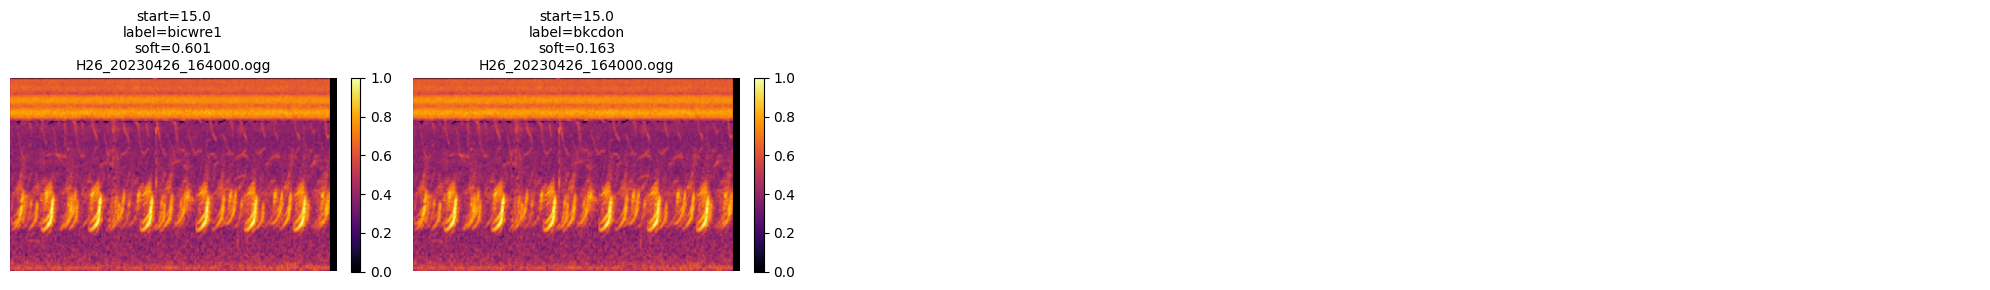

Existing Label


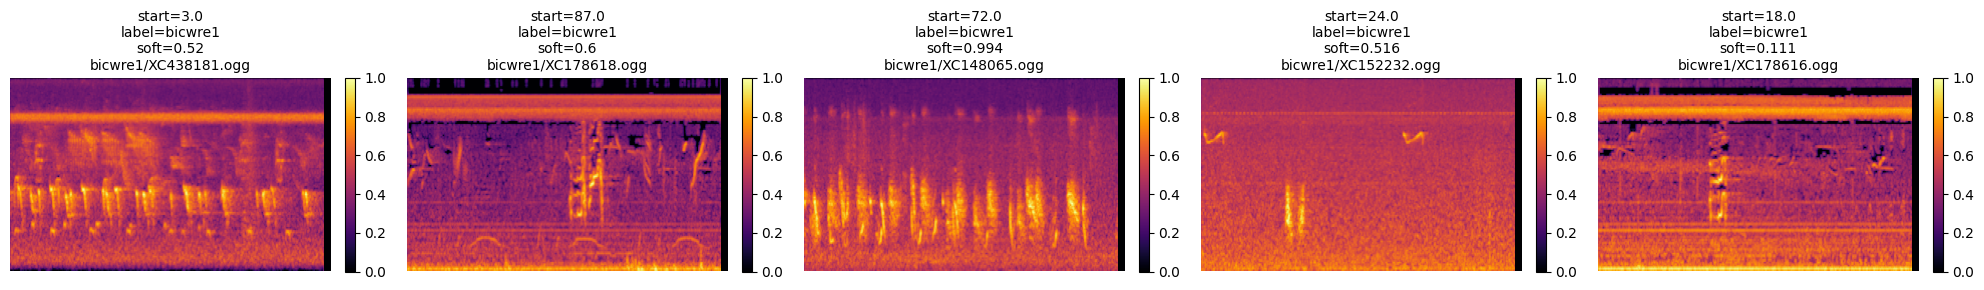

Softmax label


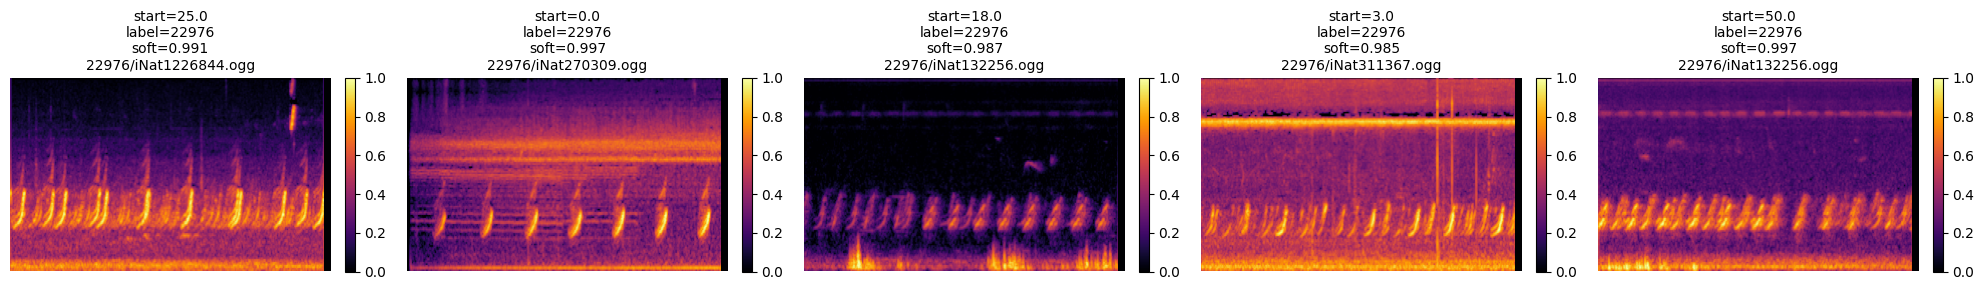

In [ ]:
def plot_spectrograms_grid(spectrograms, fnames, start_times, label_names, label_values, ncols=5):
    """
    Plot spectrograms in a grid of subplots with informative titles.
    """
    n = len(spectrograms)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))

    for idx, (spec, fname, stime, label, soft) in enumerate(zip(spectrograms, fnames, start_times, label_names, label_values)):
        ax = axes.flat[idx]
        # Plot only one channel (they are identical for color in EfficientNet)
        im = ax.imshow(spec[:, :, 0].T, origin='lower', aspect='auto', cmap='inferno')
        # Set the title containing all desired info
        title = (
            f"start={stime}\n"
            f"label={label}\n"
            f"soft={np.round(soft, 3)}\n"
            f"{fname}"
        )
        ax.set_title(title, fontsize=10)
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Hide unused axes if less than nrows * ncols
    for idx in range(n, nrows * ncols):
        axes.flat[idx].axis('off')

    plt.tight_layout()
    plt.show()
def pad_or_truncate(mel_spec, target_length):
    if mel_spec.shape[0] > target_length:
        return mel_spec[:target_length, :]
    elif mel_spec.shape[0] < target_length:
        pad_width = target_length - mel_spec.shape[0]
        return np.pad(mel_spec, ((0, pad_width), (0, 0)), mode='constant')
    else:
        return mel_spec
def _normalize(audio):
        """Normalizes the audio waveform to the range [-1, 1] based on its peak."""
        peak = np.abs(audio).max()
        if peak > 0:
            return audio / peak
        return audio

def extract_spectrograms(file_list, start_times, sr=32000, segment_duration=5.0, target_time_length_spectrogram=320,normalize=True,audio_dir='train_soundscapes'):
    """
    Extract mel spectrograms from audio files starting at given times,
    each segment exactly segment_duration seconds long (padded if shorter).

    Args:
      file_list (list of str): Paths to audio files.
      start_times (list of float): Start times (seconds) for each file segment.
      sr (int): Sampling rate for librosa.load.
      segment_duration (float): Duration (in seconds) of segment to extract.
      target_time_length_spectrogram (int): Number of mel-spectrogram frames to pad/truncate to.

    Returns:
      list of np.ndarray: List of 3-channel mel spectrogram arrays.
    """
    spectrograms = []
    for file_path, start_time in zip(file_list, start_times):
        f_path=os.path.join(main_dir,audio_dir,file_path)
        # Load the segment from file (exact segment_duration seconds, or shorter if not enough length)
        audio, _ = librosa.load(f_path, sr=sr, mono=True, offset=start_time, duration=segment_duration)
        if normalize:
          audio=_normalize(audio)
        # Extract mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T

        # Normalize to [0, 1]
        min_db, max_db = -80.0, 0.0
        mel_spec_scaled = np.clip((mel_spec_db - min_db) / (max_db - min_db), 0.0, 1.0)

        # Pad or truncate frames to fixed target length
        mel_spec_padded = pad_or_truncate(mel_spec_scaled, target_time_length_spectrogram)[:, :, np.newaxis]

        # Duplicate single channel to 3 channels for EfficientNet input
        mel_spec_padded_3_channel = np.repeat(mel_spec_padded, 3, axis=-1)

        spectrograms.append(mel_spec_padded_3_channel)
    return spectrograms
show_specs=True
sampled_data=merged_two.sample(1)

use_specific_file=True
specific_file=sampled_data['filename'].values[0]
specific_start_time=sampled_data['start_time'].values[0]
softmax_bird=sampled_data['primary_label_x'].values[0]
existing_bird=sampled_data['primary_label_y'].values[0]



path_to_data=os.path.join(csv_dir,'birdnet_soft_labels_any_label.csv')

print('Soundscape_file')
start_time=30
soundscape_data=pd.read_csv(path_to_data)
sample=soundscape_data[(soundscape_data['file']==specific_file)&(soundscape_data['start_time']==specific_start_time)]
fs=sample['file'].values
starts=sample['start_time'].values
labs=sample['primary_label'].values
conf=sample['confidence'].values
specs=extract_spectrograms(fs,starts,audio_dir='train_soundscapes')
plot_spectrograms_grid(specs, fs, starts, labs, conf)

bird_data=birdnet_data.start_time_info
print('Existing Label')

sample=bird_data[bird_data['primary_label']==existing_bird].sample(5)
fs=sample['filename'].values
starts=sample['start_time'].values
labs=sample['primary_label'].values
conf=sample['confidence'].values
specs=extract_spectrograms(fs,starts,audio_dir='train_audio')
plot_spectrograms_grid(specs, fs, starts, labs, conf)

print('Softmax label')

softmax_bird_data=birdnet_data.start_time_info_two
sample=softmax_bird_data[softmax_bird_data['primary_label']==softmax_bird].sample(5)
fs=sample['filename'].values
starts=sample['start_time'].values
labs=sample['primary_label'].values
conf=sample['confidence'].values
specs=extract_spectrograms(fs,starts,audio_dir='train_audio')
plot_spectrograms_grid(specs, fs, starts, labs, conf)


In most cases the true bird looks to be the one predicted by the softmax model and the MAE model, certainly more than the bird predicted by birdnet.  As such, I saved the existing rows with the intention of removing them.

In [ ]:
merged_two=pd.merge(good_birds,existing_data,on=['filename','start_time'])
rows_to_destroy=merged_two[['filename','start_time','primary_label_y']].rename(columns={'primary_label_y':'primary_label'})
rows_to_destroy.to_csv(os.path.join(csv_dir,'rows_to_replace1.csv'),index=False)

# **Creating Negative Samples**
- Find audio in the soundscapes which likely contains other birds not found in birdclef classes.  Add these to the training data as negative samples.

## Methodology
- Find samples where birdnet predicts a species not in birdclef classes.
- To further validate the sample only take samples where the predicted species is actually known to be in the region.

In [ ]:
# Make a dictionary of lists based on the table we discussed
species_data = {
    "species": [
        "Cnipodectes subbrunneus", "Contopus virens", "Micrastur gilvicollis",
        "Machaeropterus striolatus", "Xenops minutus", "Pitangus lictor",
        "Myiarchus tuberculifer", "Ciccaba virgata", "Piranga olivacea",
        "Schiffornis stenorhyncha", "Psiloscops flammeolus", "Sitta canadensis",
        "Todirostrum nigriceps", "Pipilo erythrophthalmus", "Coccyzus americanus",
        "Salpinctes obsoletus", "Campylopterus hemileucurus", "Pittasoma rufopileatum",
        "Otus sunia", "Trogon melanurus", "Aegolius acadicus",
        "Mionectes oleagineus", "Odontophorus gujanensis", "Rallus aquaticus",
        "Rhynchortyx cinctus", "Hylophilus flavipes", "Leptodon cayanensis",
        "Alouatta pigra", "Cyrtoxipha columbiana", "Setophaga virens",
        "Caprimulgus macrurus", "Locustella luscinioides", "Mniotilta varia",
        "Phalaenoptilus nuttallii", "Caprimulgus indicus", "Strix varia",
        "Myrmothera fulviventris", "Engine", "Phyllomyias griseiceps",
        "Chordeiles acutipennis", "Attila spadiceus", "Steatornis caripensis",
        "Vireolanius pulchellus", "Horornis acanthizoides", "Amazona farinosa",
        "Calamonastes stierlingi", "Notharchus pectoralis", "Amblycorypha longinicta",
        "Synallaxis albescens", "Helicolestes hamatus", "Willisornis poecilinotus",
        "Acris crepitans", "Phoenicurus ochruros", "Melozone crissalis"
    ],
    "taxa": [
        "Bird", "Bird", "Bird",
        "Bird", "Bird", "Bird",
        "Bird", "Bird", "Bird",
        "Bird", "Bird", "Bird",
        "Bird", "Bird", "Bird",
        "Bird", "Bird", "Bird",
        "Bird", "Bird", "Bird",
        "Bird", "Bird", "Bird",
        "Bird", "Bird", "Bird",
        "Mammal", "Insect", "Bird",
        "Bird", "Bird", "Bird",
        "Bird", "Bird", "Bird",
        "Bird", "-", "Bird",
        "Bird", "Bird", "Bird",
        "Bird", "Bird", "Bird",
        "Bird", "Bird", "Bird",
        "Insect", "Bird", "Bird",
        "Amphib", "Bird", "Bird"
    ],
    "colombia_presence": [
        "Yes", "No", "Yes",
        "Yes", "Yes", "Yes",
        "Yes", "Yes", "Rare migrant",
        "Yes", "No", "No",
        "Yes", "No", "Yes (migrant)",
        "No", "No (C. centralis yes)", "Yes",
        "No", "Yes", "No",
        "Yes", "Yes", "No",
        "Yes", "Yes", "Yes",
        "No", "Unknown/Unlikely", "No",
        "No", "No", "Yes (migrant)",
        "No", "No", "No",
        "Yes", "Not a species", "Yes",
        "Yes", "Yes", "Yes",
        "Yes", "No", "Yes",
        "No", "Yes", "No",
        "Yes", "Yes", "Yes",
        "No", "No", "No"
    ],
    "notes": [
        "Formerly broad-billed flycatcher; present in lowland forests",
        "Eastern Wood-Pewee; migrates to S America but not regularly in CO",
        "Lined Forest-Falcon; widespread in Amazonian lowland forests",
        "Striolated Manakin; found in Colombian forests",
        "Plain Xenops; widespread including Colombia",
        "Lesser Kiskadee; widespread in Colombia, riverine habitats",
        "Dusky-capped Flycatcher; common, confirmed in Middle Magdalena",
        "Mottled Owl; widespread in Colombia",
        "Scarlet Tanager; rare but possible as migrant",
        "Northern Schiffornis; restricted to Colombia/Panama",
        "Flammulated Owl; not found in Colombia",
        "Red-breasted Nuthatch; N. America, no records in Colombia",
        "Black-headed Tody-Flycatcher; occurs regionally",
        "Eastern Towhee; N. America, not Colombian",
        "Yellow-billed Cuckoo; migratory, rare visitor",
        "Rock Wren; only as vagrant, not regular",
        "Violet Sabrewing; hemileucurus: C Am., centralis found in CO",
        "Rufous-crowned Antpitta; endemic to W Colombia",
        "Oriental Scops-Owl; Asian, not in Colombia",
        "Black-tailed Trogon; widespread in Colombian lowlands",
        "Northern Saw-whet Owl; N. America, not Colombia",
        "Ochre-bellied Flycatcher; widespread",
        "Marbled Wood-Quail; various Colombian forests",
        "Water Rail; Eurasian/African, not Colombia",
        "Tawny-faced Quail; E/W Colombia border forest areas",
        "Scrub Greenlet; N Colombia & Venezuela",
        "Gray-headed Kite; widespread in S America",
        "Black Howler; Central Am., not Colombia",
        "N. American cricket, dubious for Colombia",
        "Black-throated Green Warbler; E. US, not Colombia",
        "Large-tailed Nightjar (Asia/Oceania), not Colombia",
        "Savi's Warbler (Eurasia), not in New World",
        "Black-and-white Warbler; N Am migrant, rare but possible",
        "Common Poorwill; W NA, not Colombia",
        "Indian Nightjar; Asia only",
        "Barred Owl; N Am, not Colombia",
        "Fulvous-bellied Antpitta; Chocó region in Colombia",
        "Not a species; may be spurious entry",
        "Sooty-headed Tyrannulet; present in Colombia",
        "Lesser Nighthawk; breeds in Colombia",
        "Bright-rumped Attila; widespread",
        "Oilbird; famous Colombian caves",
        "Beautiful Shrike-Vireo; rare, NW Colombia",
        "Yellow-bellied Bush-Warbler; Asia",
        "Mealy Parrot; Colombian lowlands",
        "Stierling's Wren-Warbler; Africa only",
        "White-necked Puffbird; present in Colombia",
        "US/SE Mexico katydid, not Colombia",
        "Pale-breasted Spinetail; E. Colombia",
        "Slender-billed Kite; Amazonian Colombia",
        "Common Scale-backed Antbird; Amazonian range",
        "Cricket Frog; North American, not Colombia",
        "Black Redstart; Eurasia",
        "California Towhee; W US, not Colombia"
    ]
}

# Create a DataFrame
df_species = pd.DataFrame(species_data)

# Show the DataFrame
print(df_species.head())


                     species  taxa colombia_presence  \
0    Cnipodectes subbrunneus  Bird               Yes   
1            Contopus virens  Bird                No   
2      Micrastur gilvicollis  Bird               Yes   
3  Machaeropterus striolatus  Bird               Yes   
4             Xenops minutus  Bird               Yes   

                                               notes  
0  Formerly broad-billed flycatcher; present in l...  
1  Eastern Wood-Pewee; migrates to S America but ...  
2  Lined Forest-Falcon; widespread in Amazonian l...  
3     Striolated Manakin; found in Colombian forests  
4        Plain Xenops; widespread including Colombia  


In [ ]:
print('Lookup table for the birds region (columbia or not columbia)')
df_columbia=df_species[df_species['colombia_presence']=='Yes']
df_columbia.head()

Lookup table for the birds region (columbia or not columbia)


species  taxa colombia_presence  \
0    Cnipodectes subbrunneus  Bird               Yes   
2      Micrastur gilvicollis  Bird               Yes   
3  Machaeropterus striolatus  Bird               Yes   
4             Xenops minutus  Bird               Yes   
5            Pitangus lictor  Bird               Yes   

                                               notes  
0  Formerly broad-billed flycatcher; present in l...  
2  Lined Forest-Falcon; widespread in Amazonian l...  
3     Striolated Manakin; found in Colombian forests  
4        Plain Xenops; widespread including Colombia  
5  Lesser Kiskadee; widespread in Colombia, river...

In [ ]:
# Predictions for all birds
Bnet=pd.read_csv(os.path.join(csv_dir,'birdnet_soft_labels_any_label.csv')).rename(columns={'file':'filename'})

# Join the predictions from existing MAE model
to_join=Bnet[['filename','start_time','confidence','primary_label','scientific_name']].rename(columns={'primary_label':'birdnet_primary_label'})
df_summary_merged=df_summary.merge(to_join,on=['filename','start_time'],how='left')
in_both=df_summary_merged[~df_summary_merged['birdnet_primary_label'].isna()]

# Filter to get extremely confident samples
possible_augmented_data=in_both[in_both['confidence']>0.95]
# Filter to only include non birdclef classes
unknown_labels=possible_augmented_data[possible_augmented_data['birdnet_primary_label']=='unknown']

# Format like existing data
unknown_labels['scientific_name']=None
unknown_labels['primary_label']=None
unknown_labels['end_time']=unknown_labels['start_time']+3.0

# Save to csv
unknown_labels[['filename','start_time','end_time','confidence','scientific_name','primary_label']].to_csv(os.path.join(csv_dir,'birdnet_negative_samples_data_revised.csv'),index=False)
unknown_labels[['filename','start_time','end_time','confidence','scientific_name','primary_label']]

filename  start_time  end_time  confidence  \
2993    H19_20230503_134500.ogg        33.0      36.0    0.988272   
3005    H19_20230503_134500.ogg        45.0      48.0    0.989112   
3014    H19_20230503_134500.ogg        54.0      57.0    0.988173   
17564   H19_20230427_115500.ogg        51.0      54.0    0.952038   
17909   H91_20230423_164000.ogg         0.0       3.0    0.974678   
...                         ...         ...       ...         ...   
573560  H21_20230502_144500.ogg        21.0      24.0    0.954860   
573593  H21_20230502_144500.ogg        48.0      51.0    0.952570   
575158  H03_20230428_125000.ogg        48.0      51.0    0.956325   
575164  H03_20230428_125000.ogg        54.0      57.0    0.957506   
582745  H16_20230504_113500.ogg        48.0      51.0    0.980528   

       scientific_name primary_label  
2993              None          None  
3005              None          None  
3014              None          None  
17564             None          None  
17909             None          None  
...                ...           ...  
573560            None          None  
573593            None          None  
575158            None          None  
575164            None          None  
582745            None          None  

[249 rows x 6 columns]

# **Spectrogram Plots**
These plots are intended to validate the decision to include these as negative samples.  To verify that the label predicted by the current model represents a misclassification and that the pattern actually represents the vocalization of another species outside the birdclef classes.

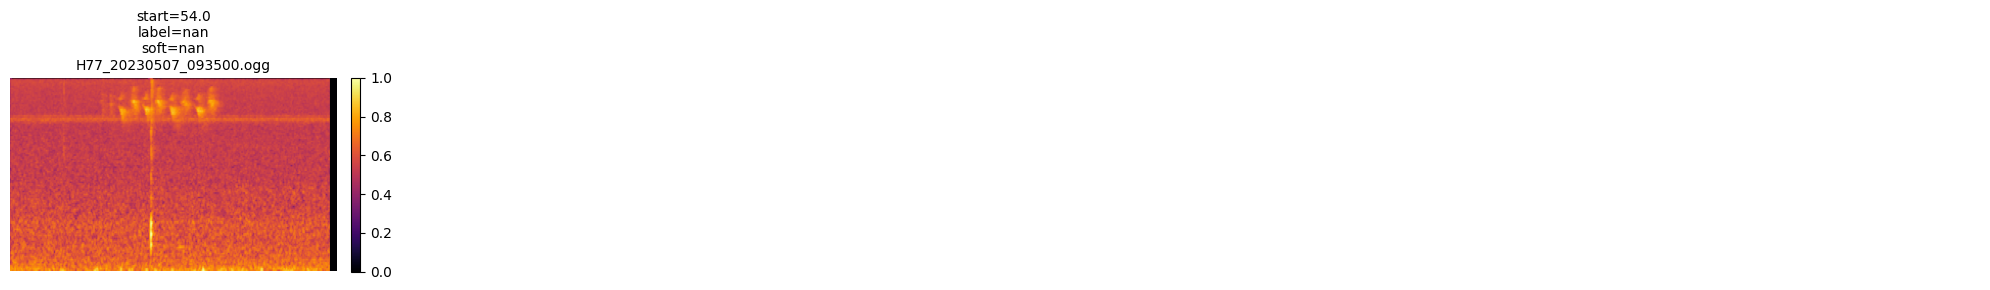

Bird predicted by MAE: banana


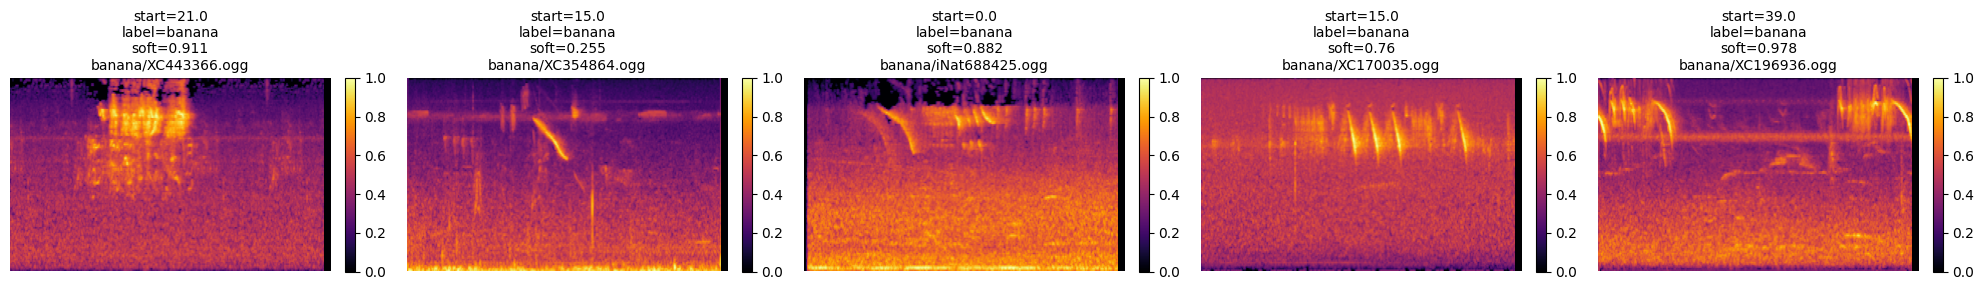

In [ ]:
# Ensure list type
df_summary_merged['birds_above_0.5'] = df_summary_merged['birds_above_0.5'].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))

# Filter for filenames AND non-empty birds_above_0.5
data_to_visualize = df_summary_merged[
    df_summary_merged['filename'].isin(unknown_labels['filename'].unique()) &
    df_summary_merged['birds_above_0.5'].apply(lambda x: len(x) > 0)
]

# Sample a row, get relevant data
sample = data_to_visualize.sample(1, random_state=41)
fs = sample['filename'].values
starts = sample['start_time'].values
labs = sample['birdnet_primary_label'].values
conf = sample['confidence'].values

# Plot spectrogram for the selected sample
specs = extract_spectrograms(fs, starts, audio_dir='train_soundscapes')
plot_spectrograms_grid(specs, fs, starts, labs, conf)

# Get the list of predicted birds for this sample
mae_predicted_birds = sample['birds_above_0.5'].values[0]
existing_labels_data = birdnet_data.data
existing_labels_data = existing_labels_data[~existing_labels_data['is_soundscape']]

# For each predicted bird, grab up to 5 samples and plot their spectrograms
for bird in mae_predicted_birds:
    print(f'Bird predicted by MAE: {bird}')
    data = existing_labels_data[existing_labels_data['primary_label'] == bird]
    # Get up to 5 samples (handle case with <5)
    n_samples = min(len(data), 5)  # up to 5 samples if available
    if n_samples == 0:
        print(f"No samples available for {bird}.")
        continue
    samples = data.sample(n=n_samples, random_state=41)
    fs = samples['filename'].values
    starts = samples['start_time'].values
    labs = samples['primary_label'].values
    conf = samples['confidence'].values
    specs = extract_spectrograms(fs, starts, audio_dir='train_audio')
    plot_spectrograms_grid(specs, fs, starts, labs, conf)


# **Generator With Mixing**

This dataset class extends our previous training data pipeline by adding audio mixup augmentation, where two audio samples are combined to create a new training example. This mixup is applied randomly with a probability of 0.3 during training for a few epochs. The mixing blends both audio waveforms and their corresponding labels, encouraging the model to generalize better by learning from composite sounds. This simple data augmentation technique improved performance slightly, helping the model better handle overlapping bird calls in real-world soundscapes.


In [ ]:
class BirdAudioDataset(Dataset):
    def __init__(self, file_list, retrieve_data_obj, num_classes, sr=32000,train=True):
        """
        Args:
            file_list: list of filenames to sample from
            retrieve_data_obj: instance of your RetreiveData class
            num_classes: total number of bird species/classes in dataset
            sr: target sample rate for audio
        """
        self.isTrain=train
        self.file_list = file_list
        self.retrieve_data = retrieve_data_obj

        self.num_classes = num_classes
        self.sr = sr
        self.chunk_duration = 5
        self.all_data=retrieve_data_obj.data
        try:
          self.start_time_info=self.all_data[~self.all_data['is_soundscape']]
        except:
          print('here 1')
        self.start_time_info=self.start_time_info[self.start_time_info['filename'].isin([f[0] for f in file_list])]
        self.soundscape_audio_info=self.all_data[self.all_data['is_soundscape']]
        self.soundscape_audio_info=self.soundscape_audio_info[self.soundscape_audio_info['filename'].isin([f[0] for f in file_list])]
        self.audio_dir=os.path.join(main_dir,'train_audio')
        self.soundscapes_dir=os.path.join(main_dir,'train_soundscapes')
        self.non_birdnet_labels=self.retrieve_data.non_birdnet_labels

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename, start_time, augment_flag, expected_bird = self.file_list[idx]
        sample_filenames=[filename]
        sample_start_times=[start_time]
        # Retrieve data from the mock object
        _, primary_labels, soft_labels, _, file_kind = self.retrieve_data.get_file_and_start_time(filename, start_time=start_time)
        #soft_labels = [1 for _ in soft_labels]
        audio_dir = 'train_soundscapes' if file_kind == 'soundscapes' else 'train_audio'
        if start_time>=1:
          start_time+=random.uniform(-0.2,0.2)
        else:
          start_time+=random.uniform(0.0,0.4)
        # Load a 5-second chunk starting from the specified time
        audio, _ = librosa.load(os.path.join(main_dir, audio_dir, filename), sr=self.sr, offset=start_time, duration=5.0)

        # Pad to 5 seconds if the chunk is shorter (e.g., at the end of the file)
        target_5s_length = 5 * self.sr
        audio_length = audio.shape[0]
        if audio_length < target_5s_length:
            pad_width = target_5s_length - audio_length
            audio = np.pad(audio, (0, pad_width), mode='constant')


        if random.random()<0.3 and self.isTrain:
          audio,primary_labels, soft_labels,add_filename,add_start_time=self._mix_files(audio,primary_labels,soft_labels,audio_type=file_kind)
          sample_filenames.append(add_filename)
          sample_start_times.append(add_start_time)
        # Apply data augmentation
        if augment_flag:
            audio = self._augment_audio(audio)

        # Create multi-hot encoded label
        multi_label = np.zeros(self.num_classes, dtype=np.float32)
        if primary_labels is not None and soft_labels is not None:
            for primary_label, soft_label in zip(primary_labels, soft_labels):
                if primary_label in self.retrieve_data.label_encoder.classes_:
                    idx_label = self.retrieve_data.label_encoder.transform([primary_label])[0]
                    multi_label[idx_label] = soft_label

        return audio, multi_label, sample_filenames,sample_start_times

    def _augment_audio(self, audio):
      """
      Applies data augmentation to the audio.
      Args:
          audio (np.ndarray): The audio waveform (5-second clip).
      Returns:
          np.ndarray: Augmented audio.
      """
      augmented_audio = audio.copy()

      # Reverb (Simple Delay-Based)
      if random.random() < 0.15:
          n_delay_samples = int(0.1 * self.sr)
          feedback = random.uniform(0.2, 0.5)
          reverberated_audio = np.zeros_like(augmented_audio)
          for i in range(len(augmented_audio)):
              reverberated_audio[i] = augmented_audio[i]
              if i >= n_delay_samples:
                  reverberated_audio[i] += feedback * reverberated_audio[i - n_delay_samples]
          augmented_audio = reverberated_audio

      # Compression (Simple Soft Clipping)
      if random.random() < 0.2:
          threshold = random.uniform(0.6, 0.9)
          gain = random.uniform(1.0, 1.5)
          compressed_audio = np.tanh(augmented_audio * gain / threshold) * threshold
          augmented_audio = compressed_audio

      # Time shifting
      if random.random() < 0.1:
          shift_seconds = random.uniform(-0.25, 0.25)
          shift_samples = int(shift_seconds * self.sr)
          augmented_audio = np.roll(augmented_audio, shift_samples)

      if random.random() < 0.05:
          clip_factor = random.uniform(0.7, 0.95)
          augmented_audio = np.clip(augmented_audio, -clip_factor, clip_factor)

      # Pitch shifting
      if random.random() < 0.05:
          n_steps = random.uniform(-0.5, 0.5)
          augmented_audio = librosa.effects.pitch_shift(augmented_audio, sr=self.sr, n_steps=n_steps)

      # Volume change
      if random.random() < 0.2:
          amplitude_factor = random.uniform(0.5, 1.3)
          augmented_audio = augmented_audio * amplitude_factor

      # Time stretching
      if random.random() < 0.1:
          augmented_audio = self.time_stretch_and_pad_truncate(augmented_audio)

      return augmented_audio

    def time_stretch_and_pad_truncate(self, audio):
        """
        Applies time stretching to a 5-second audio signal and then pads or truncates
        it to match the 5-second target length.
        """
        rate = random.uniform(0.8, 1.2)
        sr = self.sr
        target_length = self.sr * self.chunk_duration
        stretched_audio = librosa.effects.time_stretch(audio, rate=rate)

        try:
            current_length = stretched_audio.shape[0]
        except Exception as e:
            print(f'Error in stretching function: {e}')
            return audio

        if current_length < target_length:
            padding = target_length - current_length
            stretched_audio = np.pad(stretched_audio, (0, padding), mode='constant')
        elif current_length > target_length:
            stretched_audio = stretched_audio[:target_length]

        return stretched_audio

    def merge_labels_average_cap(self,primary_labels, soft_labels):
        values = defaultdict(list)
        for p, s in zip(primary_labels, soft_labels):
            values[p].append(s)
        merged_labels = []
        merged_soft_labels = []
        for p, s_list in values.items():
            label_sum= sum(s_list)
            merged_labels.append(p)
            merged_soft_labels.append(min(1.0, label_sum))
        return merged_labels, merged_soft_labels

    def mix_soundscape_with_train_audio(self, audio, existing_labels):
      # Pick random bird not in existing_labels
      start_time_info = self.start_time_info
      labels_to_consider = [lab for lab in start_time_info['primary_label'].unique()
                            if lab not in existing_labels]
      bird_to_use = random.choice(labels_to_consider)
      start_time_info = start_time_info[start_time_info['primary_label'] == bird_to_use]

      # Pick file and start time
      audio_file = random.choice(start_time_info['filename'].values)
      data_to_use = start_time_info[start_time_info['filename'] == audio_file]
      data_copy=data_to_use.copy()
      data_to_use=data_to_use[data_to_use['confidence']>0.6]

      if len(data_to_use)==0:
        data_to_use=data_copy

      start_time = random.choice(data_to_use['start_time'].values)

      # Load new audio (target = 5s clip)
      fname, primary_labels, soft_labels, start_time, file_type = \
          self.retrieve_data.get_file_and_start_time(audio_file, start_time)
      audio_path = os.path.join(self.audio_dir, audio_file)
      new_audio, _ = librosa.load(audio_path, sr=self.sr, duration=self.chunk_duration, offset=start_time)

      # ✅ Pad/tile to exactly 5 seconds BEFORE augmentation
      if len(new_audio) < self.sr * self.chunk_duration:
          repetitions = int(np.ceil(self.sr * self.chunk_duration / len(new_audio)))
          new_audio = np.tile(new_audio, repetitions)[:self.sr * self.chunk_duration]

      return new_audio, primary_labels, soft_labels, audio_file, start_time


    def mix_train_audio_with_soundscape(self, audio, existing_labels):
        start_time_info = self.soundscape_audio_info
        labels_to_consider = [lab for lab in start_time_info['primary_label'].unique()
                              if lab not in existing_labels]
        bird_to_use = random.choice(labels_to_consider)
        start_time_info = start_time_info[start_time_info['primary_label'] == bird_to_use]

        # Pick file and start time
        audio_file = random.choice(list(start_time_info['filename'].values))
        data_to_use = start_time_info[start_time_info['filename'] == audio_file]
        data_copy=data_to_use.copy()
        data_to_use=data_to_use[data_to_use['confidence']>0.6]

        if len(data_to_use)==0:
          data_to_use=data_copy
        start_time = random.choice(list(data_to_use['start_time'].values))

        # Load new audio (target = 5s clip)
        fname, primary_labels, soft_labels, start_time, file_type = \
            self.retrieve_data .get_file_and_start_time(audio_file, start_time)
        audio_path = os.path.join(self.soundscapes_dir, audio_file)
        new_audio, _ = librosa.load(audio_path, sr=self.sr, duration=self.chunk_duration, offset=start_time)

        # ✅ Pad/tile to exactly 5 seconds BEFORE augmentation
        if len(new_audio) < self.sr * self.chunk_duration:
            repetitions = int(np.ceil(self.sr * self.chunk_duration / len(new_audio)))
            new_audio = np.tile(new_audio, repetitions)[:self.sr * self.chunk_duration]

        return new_audio, primary_labels, soft_labels, audio_file, start_time


    def overlap_two_audios(self,audio1, audio2, sr, total_duration=5.0, overlap_start=2.0):
        """
        Create a new audio of length `total_duration` seconds where:
          - 0 to (overlap_start+1) uses audio1
          - overlap starts at `overlap_start` seconds: audio2's beginning is mixed in
          - Both audios are trimmed/padded as needed

        Parameters
        ----------
        audio1, audio2 : np.ndarray
            Input mono waveforms (1D arrays).
        sr : int
            Sample rate.
        total_duration : float
            Output clip length in seconds (default 5s).
        overlap_start : float
            Time in seconds where audio2 starts overlapping into audio1 (default 2s).
        """
        output_len = int(total_duration * sr)
        # Start positions in samples
        overlap_start_idx = int(overlap_start * sr)

        # Initialize empty output
        mixed_audio = np.zeros(output_len, dtype=np.float32)

        # Place first 3s of audio1 starting at t=0
        len_a1_needed = output_len
        if len(audio1) < len_a1_needed:
            reps = int(np.ceil(len_a1_needed / len(audio1)))
            audio1 = np.tile(audio1, reps)
        audio1 = audio1[:output_len]

        # Place audio1 in output
        mixed_audio += audio1

        # Place first 3s of audio2 starting at overlap_start_idx
        len_a2_needed = output_len - overlap_start_idx
        if len(audio2) < len_a2_needed:
            reps = int(np.ceil(len_a2_needed / len(audio2)))
            audio2 = np.tile(audio2, reps)
        audio2 = audio2[:len_a2_needed]

        # Mix audio2 into the overlap position
        mixed_audio[overlap_start_idx:overlap_start_idx+len(audio2)] += audio2

        # Optional: normalize to avoid clipping
        max_val = np.max(np.abs(mixed_audio))
        if max_val > 1:
            mixed_audio = mixed_audio / max_val

        return mixed_audio


    def _mix_files(self, audio,primary_labels,soft_labels,audio_type='soundscape'): # Default is to pass a soundscape file to mix with a training example
        try:
            if audio_type=='soundscape':
              new_audio,new_primary_labels,new_soft_labels,new_audio_file,new_start_time=self.mix_soundscape_with_train_audio(audio,primary_labels)
            else:
              if random.random()<0.8:
                new_audio,new_primary_labels,new_soft_labels,new_audio_file,new_start_time=self.mix_soundscape_with_train_audio(audio,primary_labels)
              else:
                new_audio,new_primary_labels,new_soft_labels,new_audio_file,new_start_time=self.mix_train_audio_with_soundscape(audio,primary_labels)


            all_labels=list(set(primary_labels+new_primary_labels))
            if any(label in self.non_birdnet_labels for label in all_labels) or random.random()<1.1:
              bird_level_noise = random.uniform(0.3, 0.7)
              other_bird_level = 1 - bird_level_noise
              mixed_audio = audio * bird_level_noise + new_audio * other_bird_level
              primary_labels=primary_labels+new_primary_labels
              soft_labels=[lab*bird_level_noise for lab in soft_labels]+[lab*other_bird_level for lab in new_soft_labels]
              primary_labels,soft_labels=self.merge_labels_average_cap(primary_labels,soft_labels)
            else:
              mixed_audio=self.overlap_two_audios(audio,new_audio,self.sr)
              primary_labels=primary_labels+new_primary_labels
              soft_labels=[(5/6)*lab for lab in soft_labels]+[(5/6)*lab for lab in new_soft_labels]
              primary_labels,soft_labels=self.merge_labels_average_cap(primary_labels,soft_labels)
            return mixed_audio,primary_labels,soft_labels,new_audio_file,new_start_time
        except Exception as e:
            print(f"Error mixing noise: {e}")
            return audio,primary_labels,soft_labels,None,None

random.shuffle(training_filenames)
train_dataset = BirdAudioDataset(training_filenames[24000:36000], birdnet_data, num_classes=206, sr=32000)
val_dataset= BirdAudioDataset(validation_filenames, birdnet_data, num_classes=206, sr=32000,train=False)
def collate_fn(batch):
    """
    batch: list of tuples (audio, multi_label, filename, start_time)

    Returns:
      - batched_audio: torch.FloatTensor of shape (batch_size, ...)
      - batched_labels: torch.FloatTensor of shape (batch_size, num_classes)
      - filenames: tuple of filenames
      - start_times: tuple of start times
    """
    # 🎯 FIX: Unpack four values from the batch
    audios, labels, filenames, start_times = zip(*batch)

    # Stack audios: convert list of np arrays to a torch tensor
    audios = torch.tensor(np.stack(audios), dtype=torch.float32)

    # Stack labels as float tensor, shape (batch_size, num_classes)
    labels = torch.tensor(np.stack(labels), dtype=torch.float32)

    # Return the four items
    return audios, labels, filenames, start_times


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)



In [ ]:
num_samples_to_check = 8
sr = 32000  # sample rate from your dataset

print(f"Playing the first {num_samples_to_check} audio samples from the DataLoader...")
print("-" * 60)

# Loop over batches — break after the first one
for batch_idx, (audio_batch, label_batch, filename_batch, start_times) in enumerate(train_loader):

    for i in range(min(len(filename_batch), num_samples_to_check)):
        filename = filename_batch[i]
        start_time = start_times[i]
        audio_tensor = audio_batch[i]
        label_tensor = label_batch[i]

        # Convert audio tensor to NumPy for IPython.display.Audio
        audio_np = audio_tensor.cpu().numpy()

        # Get indices for positive labels (label > 0 means active)
        positive_indices = torch.where(label_tensor > 0)[0].cpu().numpy()

        # Decode indices to bird names using your label encoder
        decoded_labels = label_encoder.inverse_transform(positive_indices)

        # Handle start_time formatting — works if it's a float OR a list/tuple
        if isinstance(start_time, (list, tuple, np.ndarray)):
            start_str = ",".join(f"{st:.2f}" for st in np.atleast_1d(start_time))
        else:
            start_str = f"{float(start_time):.2f}"

        # Print info for the sample
        print(f"Sample {i+1} from batch {batch_idx+1}: {filename} (start={start_str}s)")
        print(f"Decoded labels: {list(decoded_labels)}")
        print(f"Waveform shape: {audio_np.shape}, Max value: {audio_np.max():.3f}")

        # Play the audio clip inline (only works in Jupyter/Colab)
        display(Audio(data=audio_np, rate=sr))

    break  # Only inspect the first batch


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def spec_augment(mel_spectrogram, time_mask_param=8, num_time_masks=3, freq_mask_param=4, num_freq_masks=3):
    """
    Applies time and frequency masking to a single-channel spectrogram tensor.

    Args:
        mel_spectrogram: torch.Tensor, shape (time, freq).
        ... (same params as before) ...

    Returns:
        torch.Tensor: augmented mel_spectrogram (same shape as input).
    """
    augmented_mel = mel_spectrogram.clone() # Use .clone() for PyTorch tensors

    num_time_steps = augmented_mel.shape[0]
    num_freq_bins = augmented_mel.shape[1]

    # --- Time Masking ---
    for _ in range(num_time_masks):
        t = torch.randint(0, time_mask_param + 1, (1,)).item()
        if t > 0 and num_time_steps > t:
            t0 = torch.randint(0, num_time_steps - t + 1, (1,)).item()
            augmented_mel[t0:t0 + t, :] = 0

    # --- Frequency Masking ---
    if freq_mask_param is not None and num_freq_masks > 0:
        for _ in range(num_freq_masks):
            f = torch.randint(0, freq_mask_param + 1, (1,)).item()
            if f > 0 and num_freq_bins > f:
                f0 = torch.randint(0, num_freq_bins - f + 1, (1,)).item()
                augmented_mel[:, f0:f0 + f] = 0

    return augmented_mel

# ----------------- Improved Model Definition -----------------
class BirdMAEForClassification(nn.Module):
    def __init__(self, encoder, num_labels, hidden_dim=512, pooling_strategy='mean'):
        super().__init__()
        self.encoder = encoder
        self.pooling_strategy = pooling_strategy

        # Get the actual embedding dimension from the encoder
        embed_dim = encoder.config.embed_dim  # This is 768 from your config

        print(f"Creating classifier with embed_dim: {embed_dim}")

        # Create the MLP classifier head immediately
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_dim // 2, num_labels)
        )

        # Initialize classifier weights properly
        self._init_classifier_weights()

    def _init_classifier_weights(self):
        """Initialize classifier weights with proper scaling"""
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, pixel_values=None):
        outputs = self.encoder(pixel_values, return_dict=True)

        # Get the last hidden state - Bird-MAE already does global pooling
        embeddings = outputs.last_hidden_state  # Shape: [batch_size, embed_dim]

        # Pass through classifier (no pooling needed since it's already done)
        logits = self.classifier(embeddings)

        return logits

# ----------------- Loss Functions (Keep your existing ones) -----------------
class BalancedBinaryLoss(nn.Module):
    def __init__(self, weight_pos=0.49, weight_neg=0.51, epsilon=1e-7):
        super(BalancedBinaryLoss, self).__init__()
        self.weight_pos = weight_pos
        self.weight_neg = weight_neg
        self.epsilon = epsilon

    def forward(self, preds, targets):
        preds_sigmoid = torch.sigmoid(preds)
        preds_clamped = torch.clamp(preds_sigmoid, self.epsilon, 1 - self.epsilon)
        bce = F.binary_cross_entropy(preds_clamped, targets, reduction='none')

        pos_mask = (targets == 1).float()
        neg_mask = (targets == 0).float()

        pos_loss = (bce * pos_mask).sum(dim=1) / (pos_mask.sum(dim=1) + self.epsilon)
        neg_loss = (bce * neg_mask).sum(dim=1) / (neg_mask.sum(dim=1) + self.epsilon)

        balanced_loss = self.weight_pos * pos_loss + self.weight_neg * neg_loss
        return balanced_loss.mean()

class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_pos=0, gamma_neg=4, clip=0.05, eps=1e-8):
        super(AsymmetricLoss, self).__init__()
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.clip = clip
        self.eps = eps

    def forward(self, preds, targets):
        preds_sigmoid = torch.sigmoid(preds)
        preds_pos = preds_sigmoid
        preds_neg = 1 - preds_sigmoid

        if self.clip is not None and self.clip > 0:
            preds_neg = (preds_neg + self.clip).clamp(max=1)

        loss_pos = targets * torch.log(preds_pos.clamp(min=self.eps))
        loss_neg = (1 - targets) * torch.log(preds_neg.clamp(min=self.eps))

        loss_pos *= (1 - preds_pos).pow(self.gamma_pos)
        loss_neg *= (preds_pos).pow(self.gamma_neg)

        loss = - (loss_pos + loss_neg).mean()
        return loss

# Helper functions for metrics
def logits_to_preds(logits, threshold=0.5):
    probs = torch.sigmoid(logits)
    return (probs > threshold).cpu().numpy().astype(int)

def soft_labels_to_hard_labels(labels_tensor, threshold=0.5):
    return (labels_tensor > threshold).numpy().astype(int)

# ----------------- Improved Model Initialization -----------------
encoder = AutoModel.from_pretrained("DBD-research-group/Bird-MAE-Base", trust_remote_code=True)
feature_extractor = AutoFeatureExtractor.from_pretrained("DBD-research-group/Bird-MAE-Base", trust_remote_code=True)

# Debug: Print encoder configuration
print("Encoder config attributes:")
for attr in dir(encoder.config):
    if not attr.startswith('_') and not callable(getattr(encoder.config, attr)):
        try:
            value = getattr(encoder.config, attr)
            print(f"  {attr}: {value}")
        except:
            print(f"  {attr}: <error accessing>")
best_val_f1=0.8951 #0.8723 #0.8686#0.8567#0.8503 #0.8388#0.8332#0.8237 #0.7908 #0.7877
num_labels = 206
model = BirdMAEForClassification(encoder, num_labels, hidden_dim=512, pooling_strategy='mean')
# 2. Load the state dictionary
checkpoint_num=14
model_path =  os.path.join(mae_dir,f'bird_mae_classifier_checkpoint_mix_{checkpoint_num}.pt')
model.load_state_dict(torch.load(model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Asymmetrical loss function
criterion = AsymmetricLoss(gamma_pos=0, gamma_neg=5, clip=0.05)

# ----------------- Improved Optimizer Configuration -----------------
# Better learning rates with layer-wise decay
optimizer_parameters = [
    # Encoder layers with lower learning rate
    {'params': model.encoder.parameters(), 'lr': 1e-5, 'weight_decay': 0.01}, # original: 5e-5,4e-5,
    # Classifier with higher learning rate
    {'params': model.classifier.parameters(), 'lr': 5e-4, 'weight_decay': 0.01} # original: 1e-3, 9e-4,
]
optimizer = optim.AdamW(optimizer_parameters, betas=(0.9, 0.999), eps=1e-8)

# Add learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

num_epochs = 4
gradient_accumulation_steps = 16

# ----------------- Improved Training Loop -----------------
for epoch in range(num_epochs):
    # --- Training Loop ---
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    optimizer.zero_grad()

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    for batch_idx, (audio_batch, label_batch, _,_) in enumerate(train_loader, 1):
        try:
            # Convert audio to numpy if needed
            if isinstance(audio_batch[0], torch.Tensor):
                batch_np = [a.numpy() for a in audio_batch]
            else:
                batch_np = audio_batch

            # Improved feature extraction with consistent parameters
            inputs = feature_extractor(
                batch_np,
                return_tensors="pt",

                padding=True,
                truncation=True
            )
            # Handle different possible return formats from feature extractor
            if isinstance(inputs, dict):
                pixel_values = inputs['input_values'].to(device)
            else:
                pixel_values = inputs.to(device)

            # Ensure correct shape: if 3D, add channel dimension
            if len(pixel_values.shape) == 3:
                pixel_values = pixel_values.unsqueeze(1)

            labels = label_batch.to(device)

            # Forward pass
            outputs = model(pixel_values=pixel_values)
            loss = criterion(outputs, labels) / gradient_accumulation_steps
            loss.backward()

            # Gradient accumulation
            if (batch_idx % gradient_accumulation_steps == 0) or (batch_idx == len(train_loader)):
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item() * gradient_accumulation_steps

            # Calculate batch metrics
            batch_preds = logits_to_preds(outputs, threshold=0.5)
            batch_targets = soft_labels_to_hard_labels(labels.cpu(), threshold=0.5)

            all_preds.append(batch_preds)
            all_targets.append(batch_targets)

            # Calculate and display metrics every 20 batches to monitor learning
            if batch_idx % 20 == 0:
                precision = precision_score(batch_targets, batch_preds, average='samples', zero_division=0)
                recall = recall_score(batch_targets, batch_preds, average='samples', zero_division=0)
                f1 = f1_score(batch_targets, batch_preds, average='samples', zero_division=0)
                current_lr = optimizer.param_groups[0]['lr']

                # Calculate diagnostic metrics to understand what's happening
                avg_predictions_per_sample = batch_preds.sum(axis=1).mean()
                avg_labels_per_sample = batch_targets.sum(axis=1).mean()
                prediction_sparsity = (batch_preds == 0).mean()

                # Check if model is just predicting everything as positive/negative
                total_positive_preds = batch_preds.sum()
                total_positive_labels = batch_targets.sum()
                total_predictions = batch_preds.size

                # Look at the raw logits to see if they're reasonable
                with torch.no_grad():
                    logits_stats = {
                        'min': outputs.min().item(),
                        'max': outputs.max().item(),
                        'mean': outputs.mean().item(),
                        'std': outputs.std().item()
                    }

                print(f"Batch [{batch_idx:3d}/{len(train_loader)}] "
                      f"Loss: {loss.item() * gradient_accumulation_steps:.4f} "
                      f"P: {precision:.3f} R: {recall:.3f} F1: {f1:.3f} "
                      f"| Pred+: {total_positive_preds}/{total_predictions} "
                      f"Label+: {total_positive_labels} "
                      f"| Logits: μ={logits_stats['mean']:.2f} σ={logits_stats['std']:.2f} "
                      f"range=[{logits_stats['min']:.2f}, {logits_stats['max']:.2f}]")
            if batch_idx % 300 == 0:
              # Assuming 'model' is your trained BirdMAEForClassification instance
              model_path = os.path.join(mae_dir,'bird_mae_classifier_sl_mix.pt')

              # Save only the model's state dictionary
              torch.save(model.state_dict(), model_path)
              print(f"Model saved to {model_path}")
        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            continue

    # Epoch training summary
    if all_preds and all_targets:
        all_preds_epoch = np.vstack(all_preds)
        all_targets_epoch = np.vstack(all_targets)
        epoch_precision = precision_score(all_targets_epoch, all_preds_epoch, average='samples', zero_division=0)
        epoch_recall = recall_score(all_targets_epoch, all_preds_epoch, average='samples', zero_division=0)
        epoch_f1 = f1_score(all_targets_epoch, all_preds_epoch, average='samples', zero_division=0)
        avg_train_loss = running_loss / max(1, len(train_loader) // gradient_accumulation_steps)

        print(f"\nTraining Summary - Epoch {epoch+1}: "
              f"Loss: {avg_train_loss:.4f} Precision: {epoch_precision:.4f} "
              f"Recall: {epoch_recall:.4f} F1: {epoch_f1:.4f}")

    # --- Validation Loop ---
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for batch_idx, (audio_batch, label_batch, _,_) in enumerate(val_loader, 1):
            try:
                # Convert audio to numpy if needed
                if isinstance(audio_batch[0], torch.Tensor):
                    batch_np = [a.numpy() for a in audio_batch]
                else:
                    batch_np = audio_batch

                # Feature extraction - Bird-MAE expects 32kHz but no sampling_rate param
                inputs = feature_extractor(
                    batch_np,
                    return_tensors="pt"
                )

                # Handle different return formats
                if isinstance(inputs, dict):
                    pixel_values = inputs['input_values'].to(device)
                else:
                    pixel_values = inputs.to(device)

                # Ensure correct shape
                if len(pixel_values.shape) == 3:
                    pixel_values = pixel_values.unsqueeze(1)

                labels = label_batch.to(device)

                # Forward pass
                outputs = model(pixel_values=pixel_values)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                # Collect predictions and targets
                batch_preds = logits_to_preds(outputs, threshold=0.5)
                batch_targets = soft_labels_to_hard_labels(labels.cpu(), threshold=0.5)

                val_preds.append(batch_preds)
                val_targets.append(batch_targets)

            except Exception as e:
                print(f"Error in validation batch {batch_idx}: {str(e)}")
                continue

    # Validation summary
    if val_preds and val_targets:
        val_preds_epoch = np.vstack(val_preds)
        val_targets_epoch = np.vstack(val_targets)
        val_precision = precision_score(val_targets_epoch, val_preds_epoch, average='samples', zero_division=0)
        val_recall = recall_score(val_targets_epoch, val_preds_epoch, average='samples', zero_division=0)
        val_f1 = f1_score(val_targets_epoch, val_preds_epoch, average='samples', zero_division=0)
        avg_val_loss = val_running_loss / len(val_loader)

        print(f"Validation Summary - Epoch {epoch+1}: "
              f"Loss: {avg_val_loss:.4f} Precision: {val_precision:.4f} "
              f"Recall: {val_recall:.4f} F1: {val_f1:.4f}")
        if val_f1>best_val_f1:
          best_val_f1=val_f1
          model_path = os.path.join(mae_dir,f'bird_mae_classifier_checkpoint_mix_{checkpoint_num+1}.pt')
          torch.save(model.state_dict(), model_path)
          checkpoint_num+=1
          print(f"Model saved to {model_path}")
        # Update learning rate scheduler
        scheduler.step()

    print("=" * 50)

runtime.unassign()

Encoder config attributes:
  add_cross_attention: False
  architectures: ['BirdMAEModel']
  attn_drop_rate: 0.0
  attribute_map: {}
  auto_map: {'AutoConfig': 'configuration_bird_mae.BirdMAEConfig', 'AutoModel': 'modeling_bird_mae.BirdMAEModel', 'AutoModelForSequenceClassification': 'modeling_bird_mae.BirdMAEForSequenceClassification'}
  bad_words_ids: None
  base_config_key: 
  base_model_pp_plan: None
  base_model_tp_plan: None
  begin_suppress_tokens: None
  bos_token_id: None
  chunk_size_feed_forward: 0
  cross_attention_hidden_size: None
  decoder_start_token_id: None
  depth: 12
  diversity_penalty: 0.0
  do_sample: False
  drop_path_rate: 0.0
  drop_rate: 0.0
  early_stopping: False
  embed_dim: 768
  encoder_no_repeat_ngram_size: 0
  eos_token_id: None
  exponential_decay_length_penalty: None
  finetuning_task: None
  forced_bos_token_id: None
  forced_eos_token_id: None
  global_pool: mean
  has_no_defaults_at_init: False
  id2label: {0: 'LABEL_0', 1: 'LABEL_1'}
  img_size_x:

KeyboardInterrupt: 